In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import qutip as qt
from helpers import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
Ec = 60 * 2 * np.pi # mhz (anaharmonicity)
omega = 4.0e3 * 2 * np.pi # mhz (frequency of the oscillator)
dc_component = np.cos(0.269 * np.pi) # dc component of the drive
El = 0#50e3 * 2 * np.pi # mhz (inductive energy)
Ej = (omega**2 / (8 * Ec ) - El)/dc_component/2/np.pi/2 # Josephson energy
Ej

25113.06625310054

In [4]:
Ec = 60 * 2 * np.pi # mhz (anaharmonicity)
El = 20e3 * 2 * np.pi # mhz (Josephson energy)
Ej = 10e3 * 2 * np.pi # mhz (inductive energy)
dc_component = 0*np.cos(0.269 * np.pi) # dc component of the drive
omega = np.sqrt(8 * Ec * (El + 2*Ej*dc_component))  # mhz (frequency of the oscillator)
print(f"omega = {omega/2/np.pi:.2f} MHz")

omega = 3098.39 MHz


In [5]:
effective_Ej = 2* Ej * 0*dc_component
alpha = effective_Ej / (El + 2 * effective_Ej )
print(f"alpha = {alpha:.2f}")

alpha = 0.00


In [6]:
omega**2 / (8 * Ec )/2/ np.pi 

20000.000000000004

In [7]:
# linc alpha 
El = 5*Ej
alpha = 

SyntaxError: invalid syntax (2414016861.py, line 3)

In [8]:
dc_component

0.0

# Generic Floquet

In [3]:
from qutip import sigmax, sigmaz, floquet_modes

eps0 = 1.0 * 2 * np.pi
A = 0.1 * 2 * np.pi
omega = 0.02 *2* np.pi

H0 = eps0 / 2.0 * sigmaz()
H1 = A / 2.0 * sigmax()
args = {'w': omega}
H = [H0, [H1, 'sin(w * t)']]

In [154]:
T = 2*np.pi / omega
f_basis = qt.FloquetBasis(H, T, args=args)
# Calculate the Floquet modes and energies
f_energies = f_basis.e_quasi
f_modes_0 = f_basis.mode(0)
# f_modes_0, f_energies = floquet_modes(H, T, args)



In [155]:
f_energies/2/np.pi

array([-0.00124929,  0.00124929])

# Hamiltonians

## General Alice Bob Cavity Hamiltonian

Let the Hamiltonian for Alice (A), Bob (B), and a coupler mode (C), all modeled as cavity modes with annihilation operators $a$, $b$, and $c$ and frequencies $\omega_A$, $\omega_B$, $\omega_C$, be:

$$
H = \omega_A\, a^\dagger a + \omega_B\, b^\dagger b + \omega_C\, c^\dagger c  + g_{AC} (a^\dagger c + a c^\dagger) + g_{BC} (b^\dagger c + b c^\dagger)
$$

where:
- $a$, $b$, $c$ are annihilation operators for Alice, Bob, and the coupler mode,
- $a^\dagger$, $b^\dagger$, $c^\dagger$ are the corresponding creation operators,
- $g_{AC}$, $g_{BC}$ are couplings between Alice/Coupler and Bob/Coupler.

In [9]:
# Parameters for the general Alice-Bob-Cavity Hamiltonian (all units are in MHz)
omega_A = 2 * np.pi * 5e3      # Frequency of Alice's mode
omega_B = 2 * np.pi * 5.4e3      # Frequency of Bob's mode
omega_C = 2 * np.pi * 4e3      # Frequency of Coupler mode
g_AC = 2 * np.pi * 100         # Coupling between Alice and Coupler
g_BC = 2 * np.pi * 100         # Coupling between Bob and Coupler


## LINC Potential 
$$U = 2M^2E_J \cos{\phi_{ext}}\cos{\theta/M}$$
- $M$: Integer parameter related to the number of junctions or modes in the system  
- $E_J$: Josephson energy  
- $\phi_{ext}$: External flux phase  
- $\theta$: Collective phase variable, e.g., $\theta = \theta_{\mathrm{zpt}} (c + c^\dagger)$  
- $\theta_{\mathrm{zpt}} = (2E_C/E_L)^{1/4}$
- $U$: LINC potential energy

If we set $\phi_{ext} = \frac{\pi}{2} + \phi_{AC}$, then H becomes:
$$
U = 2M^2E_J \sin{\phi_{AC}}\cos{\theta/M}
$$



In [10]:
# Parameters for LINC potential (example values, adjust as needed)
M = 3                # Integer parameter (number of junctions/modes)
E_J = 2 * np.pi * 15e3    # Josephson energy (in appropriate units)
# phi_AC = np.pi / 4   # Phase variable (in radians)
E_C = 2 * np.pi * 100e3   # Charging energy
E_L = 2 * np.pi * 52.8    # Inductive energy


In [201]:
##

## Rough Strategy 
- Go TO RW frame of LINC, and cavities. Effective hamiltonian has the JC terms which gain exponential rotation and so does the E_J term 

- Now for each drive amplitude, find the resonant frequency of the beamsplitter
    - Do this simply be sweeping across different drive frequency and picking the frequency where we see a significant hybridization of alice and bob modes
- At the resonant frequency, extract the kerr using the higher levels (drive induced kerr shift)

In [11]:
from helpers import CouplerHamiltonian


In [225]:
coup_ham = CouplerHamiltonian(
    trunc=4,
    omega_A=omega_A,
    omega_B=omega_B,
    omega_C=omega_C,
    g_AC=g_AC,
    g_BC=g_BC,
    E_C=E_C,
    E_L=E_L,
    E_J=E_J
)

Initializing CouplerHamiltonian with truncation: 4
In lab frame


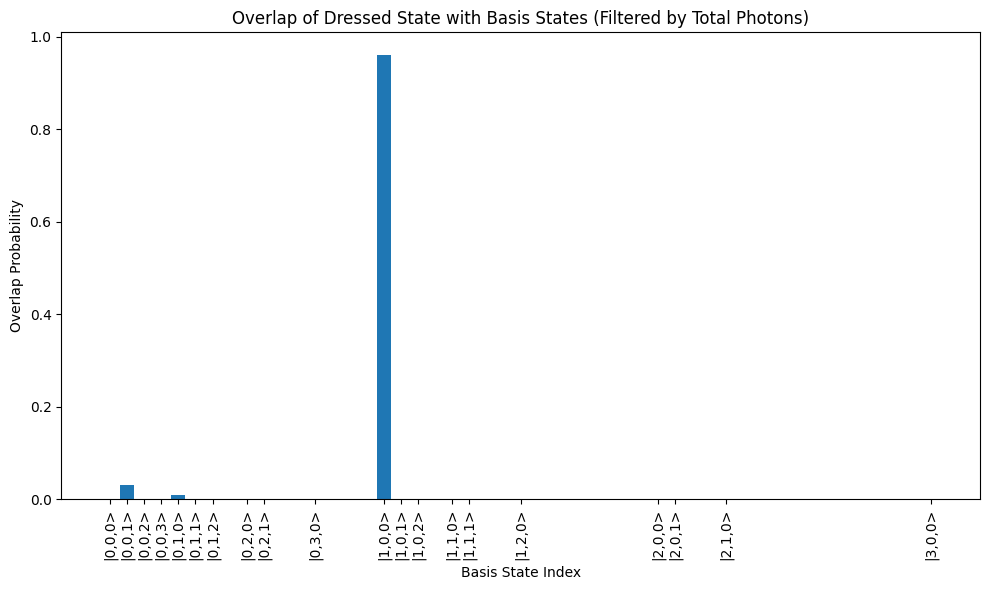

In [226]:
state_label = '|1,0,0>'
basis_idx = coup_ham.ket_to_basis_index(state_label)
dressed_idx = coup_ham.basis_to_dressed_mapping_dict[basis_idx]
coup_ham.plot_dressed_state_overlap(coup_ham.dressed_states[dressed_idx])

In [227]:
# get energies of alice and bob single photon dressed states
alice_energy = coup_ham.dressed_static_energies[coup_ham.basis_to_dressed_mapping_dict[coup_ham.ket_to_basis_index('|1,0,0>')]]
bob_energy = coup_ham.dressed_static_energies[coup_ham.basis_to_dressed_mapping_dict[coup_ham.ket_to_basis_index('|0,1,0>')]]
print(f"Alice single photon dressed state energy: {alice_energy/2/np.pi:.2f} MHz")
print(f"Bob single photon dressed state energy: {bob_energy/2/np.pi:.2f} MHz")
# Get the difference in energy
energy_diff = bob_energy - alice_energy
print(f"Energy difference between Alice and Bob single photon dressed states: {energy_diff/2/np.pi:.2f} MHz")

Alice single photon dressed state energy: 5031.85 MHz
Bob single photon dressed state energy: 5426.53 MHz
Energy difference between Alice and Bob single photon dressed states: 394.68 MHz


In [228]:
# calculate dressed state energy of 012 state
state_label = '|0,1,2>'
basis_idx = coup_ham.ket_to_basis_index(state_label)
dressed_idx = coup_ham.basis_to_dressed_mapping_dict[basis_idx]
dressed_energy = coup_ham.dressed_static_energies[dressed_idx]
print(f"Dressed state energy of {state_label}: {dressed_energy/2/np.pi:.2f} MHz")


Dressed state energy of |0,1,2>: 13292.64 MHz


In [229]:
983/980

1.0030612244897958

### Floquet Mode Calculation (Single)

In [278]:
# now get floquet modes 
omegad = 2 * np.pi * 390 # Floquet drive frequency
amp = 0.001
H0 = coup_ham.H0
operator, time_func = coup_ham.linc_potential_operator()
H_fq = [H0, [operator, time_func]]
f_energies, f_modes = coup_ham.floquet_modes(H_fq, omegad, args={'phi_AC_amp': amp, 'omega': omegad})
dressed_to_floquet_mapping, floquet_to_dressed_mapping = coup_ham.dressed_to_floquet_mapping(f_modes)

/opt/anaconda3/envs/quantum/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


In [279]:
operator.shape

(64, 64)

Dressed state index: 3
Floquet state index: 31
Overlaps with dressed states: [1.252565620487182e-35, 5.143166948913384e-05, 0.09614716295222085, 0.9036111102364631, 1.2365645716784655e-32, 4.383882084793375e-31, 7.408418717781585e-32, 8.434629568733178e-32, 9.776767943760426e-33, 1.8706788464865e-31, 6.759318642759587e-08, 1.75159887977783e-05, 0.00015871388596372087, 1.4369523790499336e-06, 3.6266596155529546e-06, 8.642676841045765e-06, 2.300721502501945e-08, 1.6069812037316398e-08, 1.428413817250717e-07, 9.157549768889245e-08, 3.479319065563974e-31, 3.5248281655619803e-31, 4.2987605287751113e-32, 4.4862857153648464e-31, 2.2831866230221043e-31, 1.8059547754284284e-32, 5.687803017629058e-32, 9.112679430038452e-31, 6.165333047718316e-33, 2.1286034392778072e-32, 5.47749883033016e-32, 1.2860795610109467e-31, 3.4000151970285576e-12, 1.4250682244444615e-11, 1.8052888428228057e-11, 8.247426162026112e-13, 2.6007297359543668e-14, 2.5699758180871134e-12, 2.0137993205479085e-12, 1.56515427075168

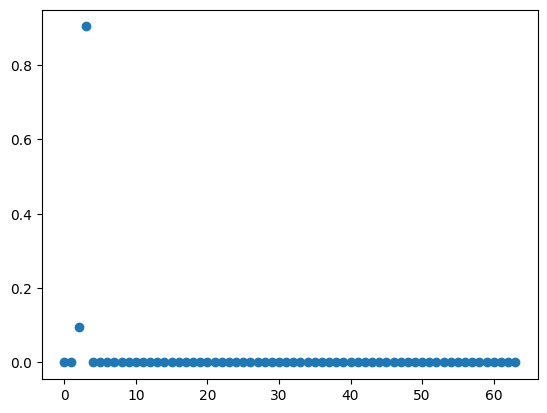

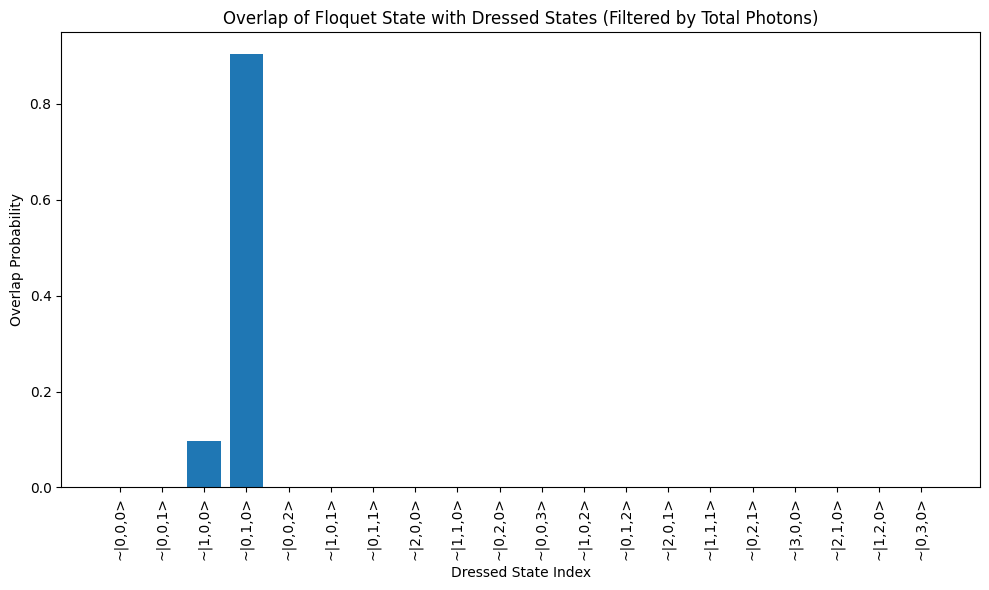

In [280]:
# map floquet modes to dressed modes 
floquet_state_to_plot = '|0,1,0>'  # Bob's state
# Find the index of associated dressed state and then apply the dressed to floquet mapping
dressed_idx = coup_ham.basis_to_dressed_mapping_dict[coup_ham.ket_to_basis_index(floquet_state_to_plot)]
print(f"Dressed state index: {dressed_idx}")
floquet_idx = dressed_to_floquet_mapping[dressed_idx]
print(f"Floquet state index: {floquet_idx}")
coup_ham.plot_floquet_state_overlap(f_modes[floquet_idx])

In [281]:
# find teh quasienergies of alice and bob floquet single photon states
alice_floquet_idx = dressed_to_floquet_mapping[coup_ham.basis_to_dressed_mapping_dict[coup_ham.ket_to_basis_index('|1,0,0>')]]
bob_floquet_idx = dressed_to_floquet_mapping[coup_ham.basis_to_dressed_mapping_dict[coup_ham.ket_to_basis_index('|0,1,0>')]]
alice_floquet_energy = f_energies[alice_floquet_idx]
bob_floquet_energy = f_energies[bob_floquet_idx]
print(f"Alice single photon Floquet state energy: {alice_floquet_energy/2/np.pi:.2f} MHz")
print(f"Bob single photon Floquet state energy: {bob_floquet_energy/2/np.pi:.2f} MHz")
# Get the difference in energy
energy_diff_floquet = bob_floquet_energy - alice_floquet_energy

Alice single photon Floquet state energy: -39.13 MHz
Bob single photon Floquet state energy: -33.51 MHz


Plus Floquet state energy: -33.51 MHz
Minus Floquet state energy: -39.13 MHz
Overlaps with dressed states: [1.252565620487182e-35, 5.143166948913384e-05, 0.09614716295222085, 0.9036111102364631, 1.2365645716784655e-32, 4.383882084793375e-31, 7.408418717781585e-32, 8.434629568733178e-32, 9.776767943760426e-33, 1.8706788464865e-31, 6.759318642759587e-08, 1.75159887977783e-05, 0.00015871388596372087, 1.4369523790499336e-06, 3.6266596155529546e-06, 8.642676841045765e-06, 2.300721502501945e-08, 1.6069812037316398e-08, 1.428413817250717e-07, 9.157549768889245e-08, 3.479319065563974e-31, 3.5248281655619803e-31, 4.2987605287751113e-32, 4.4862857153648464e-31, 2.2831866230221043e-31, 1.8059547754284284e-32, 5.687803017629058e-32, 9.112679430038452e-31, 6.165333047718316e-33, 2.1286034392778072e-32, 5.47749883033016e-32, 1.2860795610109467e-31, 3.4000151970285576e-12, 1.4250682244444615e-11, 1.8052888428228057e-11, 8.247426162026112e-13, 2.6007297359543668e-14, 2.5699758180871134e-12, 2.01379932

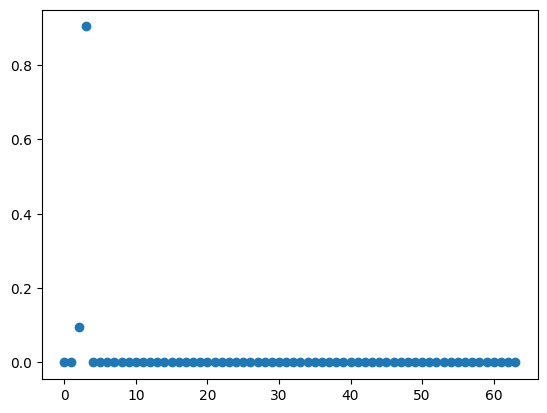

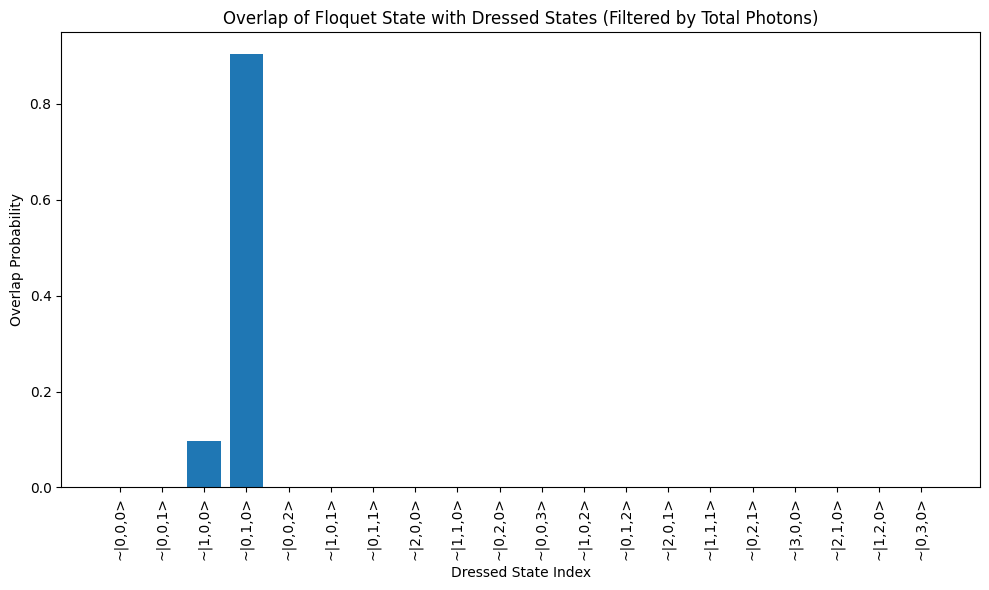

Overlaps with dressed states: [2.099567762538938e-36, 0.0004187172205711837, 0.9033616701112706, 0.09602314519084985, 7.81870731417247e-34, 1.201559611553868e-31, 4.080798591532718e-32, 1.3161827651430783e-31, 3.351804342684193e-32, 2.1434452271678596e-32, 4.862005975595053e-07, 0.00015644437209349978, 1.6243512392248328e-05, 1.3302150695632436e-05, 8.47844211384534e-06, 9.049329031444648e-07, 2.1283873980411214e-07, 2.7236379569444037e-07, 1.0059773440451944e-07, 9.64527074134882e-09, 1.328576116098272e-32, 8.336427585696104e-32, 2.823914247443114e-32, 1.7368843319690168e-32, 1.791619688859837e-32, 1.7600350794559914e-32, 1.1563891649365017e-33, 3.743573162628097e-32, 1.0461111977494648e-32, 5.684337338162637e-32, 7.441979625059429e-32, 1.4392110546071587e-31, 2.0375863900096585e-11, 1.1604680272821486e-12, 6.360379952533743e-13, 1.4067914198453726e-12, 2.639182089164371e-12, 3.109295609627773e-13, 1.0842049802371142e-14, 1.2234950609591716e-13, 1.155325274989803e-13, 6.79872565833443

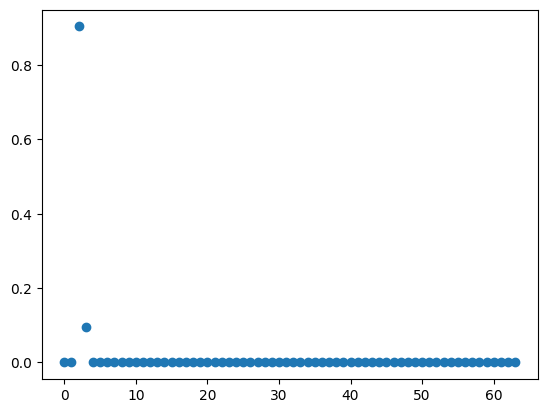

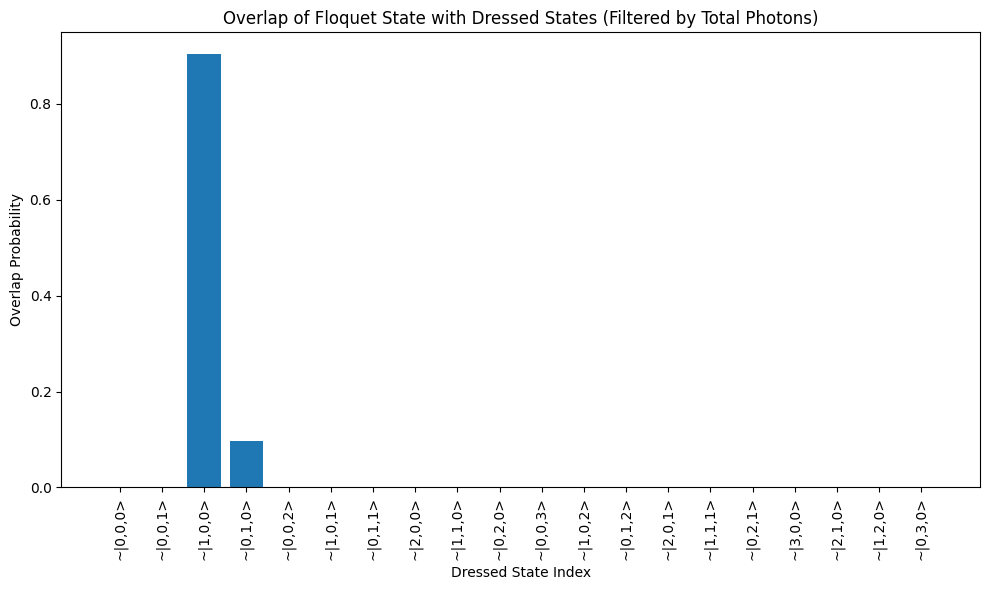

In [282]:
alice_dressed_idx = coup_ham.basis_to_dressed_mapping_dict[coup_ham.ket_to_basis_index('|1,0,0>')]
bob_dressed_idx = coup_ham.basis_to_dressed_mapping_dict[coup_ham.ket_to_basis_index('|0,1,0>')]
alice_dressed_state = coup_ham.dressed_states[alice_dressed_idx]
bob_dressed_state = coup_ham.dressed_states[bob_dressed_idx]

plus_state = (alice_dressed_state + bob_dressed_state) / np.sqrt(2)
minus_state = (alice_dressed_state - bob_dressed_state) / np.sqrt(2)

# Find the floquet states with largest overlap with the plus and minus states
plus_floquet = f_modes[coup_ham.find_max_overlap_indices(plus_state, f_modes)[0]]
minus_floquet = f_modes[coup_ham.find_max_overlap_indices(minus_state, f_modes)[0]]
plus_floquet_energy = f_energies[coup_ham.find_max_overlap_indices(plus_state, f_modes)[0]]
minus_floquet_energy = f_energies[coup_ham.find_max_overlap_indices(minus_state, f_modes)[0]]
print(f"Plus Floquet state energy: {plus_floquet_energy/2/np.pi:.2f} MHz")
print(f"Minus Floquet state energy: {minus_floquet_energy/2/np.pi:.2f} MHz")
# plot the plus and minus floquet states
coup_ham.plot_floquet_state_overlap(plus_floquet)
coup_ham.plot_floquet_state_overlap(minus_floquet)

### Floquet Mode Calucaltion Sweep Amplitudes
# Plus Floquet state energy: -84.99 MHz
# Minus Floquet state energy: -103.72 MHz
# Overlaps with dressed states: [7.067273144566706e-32, 0.061898877981625224, 0.11444186627787145, 0.45609081727612416, 4.662416142568583e-33, 6.419163726408339e-32, 1.5207651287285073e-32, 1.6817123820301386e-33, 9.553120183649983e-32, 5.972293347271185e-34, 0.01201332032285202, 0.06545620089778657, 0.1912888023039997, 0.000595777276564865, 0.0022265168289336843, 0.03299389065681325, 3.204995316250883e-05, 0.0016914130783895528, 0.0033793887821194912, 8.152897980280146e-05, 1.6936132801156063e-31, 1.5078732335815586e-31, 4.551882227840072e-32, 6.159481900986614e-32, 8.533416131437458e-32, 1.889155260682823e-32, 1.8926438366421843e-31, 5.087774667005346e-31, 8.913138316898243e-33, 4.3453671575313974e-32, 8.919647914241008e-32, 9.506739470904616e-32, 0.0017011765690348197, 0.00792005248308294, 0.010790795483183353, 0.0022883317044525356, 0.0013781823067218761, 0.0006137184195980251, 0.00025462733018456567, 0.004067188744316352, 0.004255069375473745, 3.909373396615837e-05, 0.008691498541370567, 7.96833236116795e-05, 9.580252866681082e-33, 7.152403571749463e-32, 3.1640174745942223e-31, 2.465083877148359e-32, 1.047817656686608e-31, 4.840666328644499e-31, 5.718653628880173e-32, 7.580193686210997e-33, 6.76948747493635e-32, 1.77160521712533e-32, 0.000428968326737598, 0.005143792493444927, 0.00021284339742504992, 0.008745709401417414, 6.854080417727275e-05, 0.0006439549583231775, 1.4574903917506418e-31, 5.416978322863857e-32, 1.43587403945429e-32, 8.672745743249996e-05]

In [276]:
coup_ham.find_max_overlap_indices(plus_state, f_modes)

[13]

In [277]:
f_modes[0]

Quantum object: dims=[[4, 4, 4], [1]], shape=(64, 1), type='ket', dtype=Dense
Qobj data =
[[-6.95667685e-17+2.71764276e-17j]
 [-1.92307747e-03-3.62960873e-06j]
 [-3.88838587e-17-1.84646352e-17j]
 [-3.78311563e-03+4.37928985e-06j]
 [-1.83839522e-02+3.42346938e-06j]
 [ 1.55595501e-16+3.03227651e-16j]
 [-3.90164627e-03-1.13871716e-05j]
 [ 2.18003815e-16+5.27299102e-17j]
 [ 2.76000921e-16-2.87340765e-17j]
 [ 5.60040343e-02+1.04309655e-04j]
 [ 1.66003322e-16-9.63872100e-17j]
 [ 2.09889787e-02-9.02839432e-05j]
 [ 6.06845100e-01+2.91279258e-04j]
 [-3.31655811e-16+2.04720702e-16j]
 [-7.36102545e-01-4.50817762e-06j]
 [ 4.58700829e-17-6.24170061e-17j]
 [ 4.17686213e-03+2.18840265e-06j]
 [ 4.87833442e-17+1.01366810e-16j]
 [-2.74948952e-04+1.82360711e-06j]
 [ 2.13399693e-16-2.31425835e-16j]
 [-2.96362569e-16-6.85061297e-17j]
 [ 2.83477847e-02-1.06136163e-05j]
 [ 2.45529147e-17+1.49060924e-16j]
 [-5.79091441e-02-1.69770915e-05j]
 [-1.38242111e-01-1.45821045e-04j]
 [-2.25632071e-16-1.17753370e-16j]


# Floquet Example with simpler Two Mode Hamiltonian

In [413]:
two_mode = TwoModeHamiltonian(omega_A=2*np.pi * 5e3, omega_B=2*np.pi * 6e3,
                              trunc = 4)

omega_drive = 2 * np.pi * 999
eps = 0.1
args = {'omega': omega_drive, 'amp': eps}

floquet_class = FloquetHamiltonian(H = two_mode.H, T=2*np.pi/omega_drive, args=args)
min_amp = 0 * 2 * np.pi
max_amp = 100 * 2 * np.pi
return_args = floquet_class.sweep_ac_drive_amplitude(omega, amp_range = (min_amp, max_amp), num_points=50)

/opt/anaconda3/envs/quantum/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
Computing Floquet modes:   0%|          | 0/50 [00:00<?, ?it/s]/opt/anaconda3/envs/quantum/lib/python3.12/site-packages/scipy/integrate/_ode.py:431: UserWarning: _zvode: Excess work done on this call. (Perhaps wrong MF.)
  self._y, self.t = mth(self.f, self.jac or (lambda: None),
Computing Floquet modes:   0%|          | 0/50 [00:00<?, ?it/s]


IntegratorException: Excess work done on this call. Try to increasing the nsteps parameter in the Options class

In [415]:

floquet_class = FloquetHamiltonian(H = two_mode.H, T=2*np.pi/omega_drive, args=args)
min_freq = 10 * 2 * np.pi
max_amp = 3000 * 2 * np.pi
amp = 50* 2 * np.pi
return_args = floquet_class.sweep_ac_drive_frequency(amp, freq_range = (min_freq, max_amp), num_points=500)

Computing Floquet modes: 100%|██████████| 500/500 [00:18<00:00, 26.77it/s]


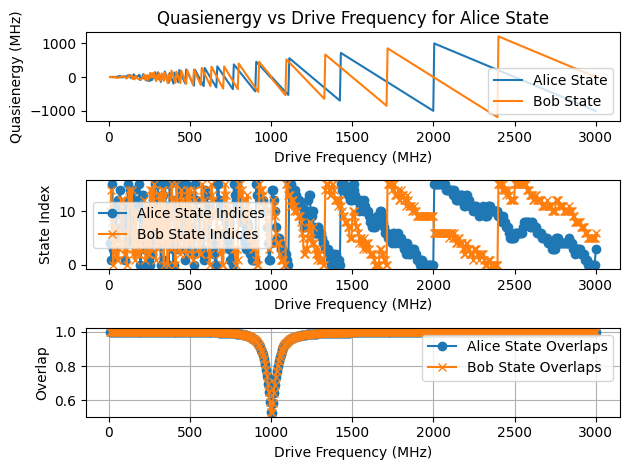

In [416]:
freqs = return_args['frequencies']
energies = return_args['energies']
modes = return_args['modes']

# alice basis state 
alice_state = two_mode.get_basis_state(1,0)
bob_state = two_mode.get_basis_state(0,1)

# for each point in the frequency sweep, find the mode with the largest overlap with the alice state
# its index and finally plot the energies of the modes with the largest overlap

alice_max_overlaps_idxs = []
bob_max_overlaps_idxs = []
alice_overlaps= []
bob_overlaps = []

for i in range(len(freqs)):
    alice_overlap_indices, alice_overlap = floquet_class.find_max_overlap_indices(alice_state, modes[i], return_overlaps=True)
    bob_overlap_indices, bob_overlap = floquet_class.find_max_overlap_indices(bob_state, modes[i], return_overlaps=True)
    alice_max_overlaps_idxs.append(alice_overlap_indices[0])
    bob_max_overlaps_idxs.append(bob_overlap_indices[0])
    alice_overlaps.append(alice_overlap[0])
    bob_overlaps.append(bob_overlap[0])

    

#################
# plot the energies and the indices (one plot for each)
plt.subplot(3, 1, 1)
plt.plot(freqs / 2 / np.pi, np.array([energies[i][alice_max_overlaps_idxs[i]] for i in range(len(energies))]) / 2 / np.pi, label='Alice State')
plt.plot(freqs/2/np.pi, np.array([energies[i][bob_max_overlaps_idxs[i]] for i in range(len(energies))])/2/np.pi, label='Bob State')
plt.xlabel('Drive Frequency (MHz)')
plt.ylabel('Quasienergy (MHz)')
plt.title('Quasienergy vs Drive Frequency for Alice State')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(freqs / 2 / np.pi, alice_max_overlaps_idxs, label='Alice State Indices', marker='o')
plt.plot(freqs / 2 / np.pi, bob_max_overlaps_idxs, label='Bob State Indices', marker='x')
plt.xlabel('Drive Frequency (MHz)')
plt.ylabel('State Index')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(freqs / 2 / np.pi, alice_overlaps, label='Alice State Overlaps', marker='o')
plt.plot(freqs / 2 / np.pi, bob_overlaps, label='Bob State Overlaps', marker='x')
plt.xlabel('Drive Frequency (MHz)')
plt.ylabel('Overlap')
plt.legend()
plt.grid()
plt.tight_layout()


Min overlap at index 166: 0.5278836633201573 for swept parameter 6312.5236273513865


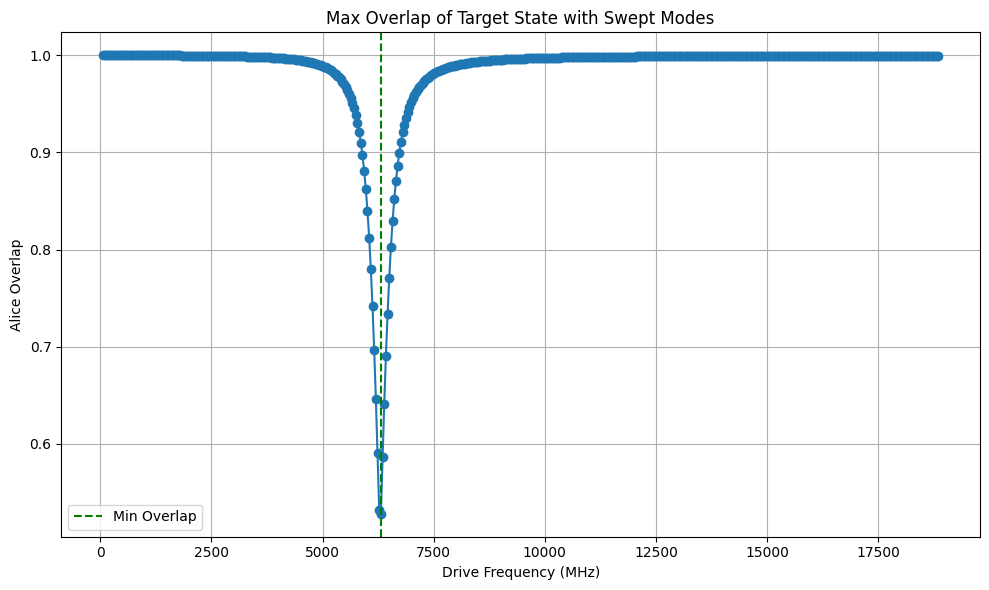

In [435]:
return_args = floquet_class.plot_overlaps_state(freqs, alice_state, modes, xlabel = 'Drive Frequency (MHz)', ylabel='Alice Overlap', 
                                                find_min=True, find_max = False)

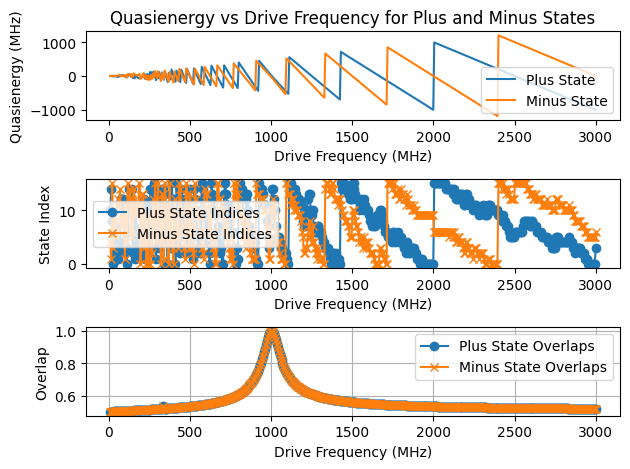

In [417]:
# alice basis state 
alice_state = two_mode.get_basis_state(1,0)
bob_state = two_mode.get_basis_state(0,1)

# Define plus and minus states
plus_state = (alice_state + 1.0j *bob_state) / np.sqrt(2)
minus_state = (alice_state - 1.0j *bob_state) / np.sqrt(2)

# for each point in the frequency sweep, find the mode with the largest overlap with the plus and minus states
plus_max_overlaps_idxs = []
minus_max_overlaps_idxs = []
plus_max_overlaps = []
minus_max_overlaps = []
for i in range(len(freqs)):
    plus_overlap_idxs, plus_overlaps = floquet_class.find_max_overlap_indices(plus_state, modes[i], return_overlaps=True)
    plus_max_overlaps.append(plus_overlaps[0])
    minus_overlap_idxs, minus_overlaps = floquet_class.find_max_overlap_indices(minus_state, modes[i], return_overlaps=True)
    minus_max_overlaps.append(minus_overlaps[0])
    
    plus_max_overlaps_idxs.append(plus_overlap_idxs[0])
    minus_max_overlaps_idxs.append(minus_overlap_idxs[0])

#################
# plot the energies and the indices (one plot for each)
plt.subplot(3, 1, 1)
plt.plot(freqs / 2 / np.pi, np.array([energies[i][plus_max_overlaps_idxs[i]] for i in range(len(energies))]) / 2 / np.pi, label='Plus State')
plt.plot(freqs / 2 / np.pi, np.array([energies[i][minus_max_overlaps_idxs[i]] for i in range(len(energies))]) / 2 / np.pi, label='Minus State')
plt.xlabel('Drive Frequency (MHz)')
plt.ylabel('Quasienergy (MHz)')
plt.title('Quasienergy vs Drive Frequency for Plus and Minus States')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(freqs / 2 / np.pi, plus_max_overlaps_idxs, label='Plus State Indices', marker='o')
plt.plot(freqs / 2 / np.pi, minus_max_overlaps_idxs, label='Minus State Indices', marker='x')
plt.xlabel('Drive Frequency (MHz)')
plt.ylabel('State Index')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(freqs / 2 / np.pi, plus_max_overlaps, label='Plus State Overlaps', marker='o')
plt.plot(freqs / 2 / np.pi, minus_max_overlaps, label='Minus State Overlaps', marker='x')
plt.xlabel('Drive Frequency (MHz)')
plt.ylabel('Overlap')
plt.legend()

plt.grid()
plt.tight_layout()



Fitted parameters:
Center (x0): 1005.9678834887325
Width (gamma): 96.95335743205611
Amplitude: 0.4417694009289325
Offset: 0.5245412562621165


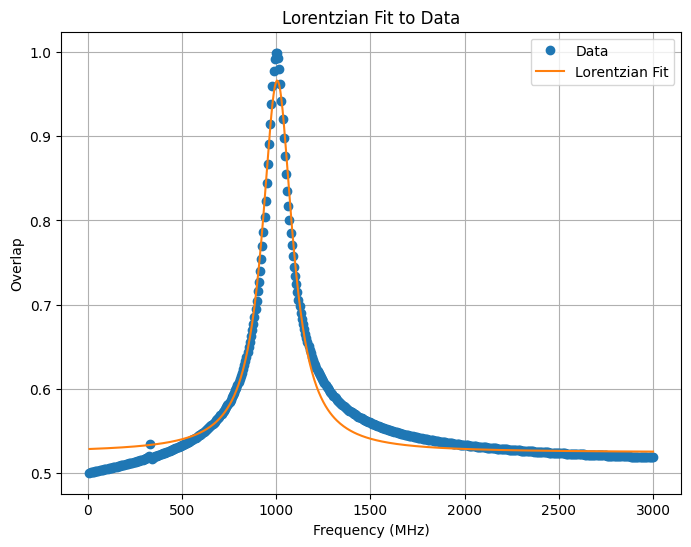

In [421]:
from scipy.optimize import curve_fit

xlist = freqs / 2 / np.pi
ylist = plus_max_overlaps
# Define a Lorentzian function
def lorentzian(x, x0, gamma, amplitude, offset):
    return amplitude * (gamma**2 / ((x - x0)**2 + gamma**2)) + offset

# Fit the data to the Lorentzian function
popt, pcov = curve_fit(lorentzian, xlist, ylist, p0=[1000, 1, max(ylist), min(ylist)])

# Extract the fitted parameters
x0, gamma, amplitude, offset = popt
print(f"Fitted parameters:\nCenter (x0): {x0}\nWidth (gamma): {gamma}\nAmplitude: {amplitude}\nOffset: {offset}")

# Plot the original data and the fitted Lorentzian
plt.figure(figsize=(8, 6))
plt.plot(xlist, ylist, 'o', label='Data')
plt.plot(xlist, lorentzian(xlist, *popt), '-', label='Lorentzian Fit')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Overlap')
plt.title('Lorentzian Fit to Data')
plt.legend()
plt.grid()
plt.show()

In [422]:
idx = np.argmax(ylist)
print(f"Maximum overlap occurs at frequency: {xlist[idx]} MHz")

Maximum overlap occurs at frequency: 1004.6693386773546 MHz


Plus state energy at 1000 MHz: -0.83 MHz
Minus state energy at 1000 MHz: -50.99 MHz
Energy difference at 1000 MHz: -50.16 MHz


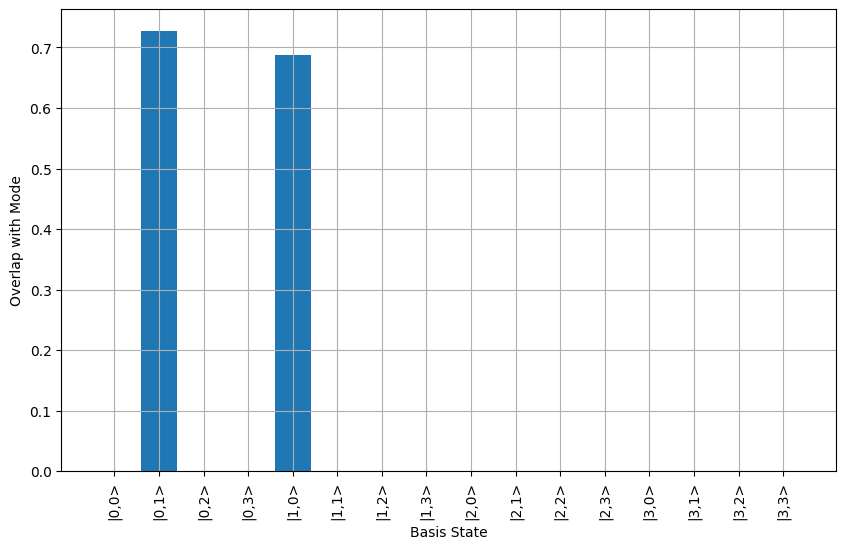

In [424]:
# get index of freq = 1000 MHz
freq_index = np.argmin(np.abs(freqs - 1004 * 2 * np.pi))
mode = modes[freq_index][minus_max_overlaps_idxs[freq_index]]

plus_energy = energies[freq_index][plus_max_overlaps_idxs[freq_index]]
minus_energy = energies[freq_index][minus_max_overlaps_idxs[freq_index]]
print(f"Plus state energy at 1000 MHz: {plus_energy / 2 / np.pi:.2f} MHz")
print(f"Minus state energy at 1000 MHz: {minus_energy / 2 / np.pi:.2f} MHz")
#print the difference in energy
energy_diff = minus_energy - plus_energy
print(f"Energy difference at 1000 MHz: {energy_diff / 2 / np.pi:.2f} MHz")

# plot the mode as a function of basis state 
basis_states, ket_labels = two_mode.get_all_basis_states()

# get the overlaps of the mode with all basis states
overlaps = [mode.overlap(basis_state) for basis_state in basis_states]
plt.figure(figsize=(10, 6))
plt.bar(range(len(overlaps)), np.abs(overlaps), tick_label=basis_states)
plt.xlabel('Basis State')
plt.ylabel('Overlap with Mode')
plt.xticks(range(len(ket_labels)), ket_labels, rotation=90)

plt.grid()



In [ ]:
# find teh effective g 


# Floquet sweeps on coupler hamiltonian

In [9]:
# Parameters for LINC potential (example values, adjust as needed)
M = 1               # Integer parameter (number of junctions/modes)
E_J = 2 * np.pi * 15e3    # Josephson energy (in appropriate units)
# phi_AC = np.pi / 4   # Phase variable (in radians)
E_C = 2 * np.pi * 100e3   # Charging energy
E_L = 2 * np.pi * 52.8    # Inductive energy

# Parameters for the general Alice-Bob-Cavity Hamiltonian (all units are in MHz)
omega_A = 2 * np.pi * 4.9e3      # Frequency of Alice's mode
omega_B = 2 * np.pi * 6.0e3      # Frequency of Bob's mode
omega_C = 2 * np.pi * 6.5e3      # Frequency of Coupler mode
g_AC = 2 * np.pi * 100         # Coupling between Alice and Coupler
g_BC = 2 * np.pi * 50         # Coupling between Bob and Coupler


In [50]:
coup_ham = CouplerHamiltonian(
    trunc=4,
    omega_A=omega_A,
    omega_B=omega_B,
    omega_C=omega_C,
    g_AC=g_AC,
    g_BC=g_BC,
    E_C=E_C,
    E_L=E_L,
    E_J=E_J
)
# more coupler lebvels 

Initializing CouplerHamiltonian with truncation: 4
Adding couplings to Hamiltonian
In lab frame


### Digression

In [624]:
omegad = 2 * np.pi * 450 # Floquet drive frequency
amp = 0.03
args = {'amp': amp, 'omega': omegad}

H0 = coup_ham.generate_H0(no_coupling=True)
operator, time_func = coup_ham.linc_potential_operator()

H_fq = [H0, [operator, time_func]]
floquet_class= FloquetHamiltonian(H = H_fq, T=2*np.pi/omegad, args=args)

f_energies, f_modes = floquet_class.compute_floquet_modes()



No couplings added to Hamiltonian


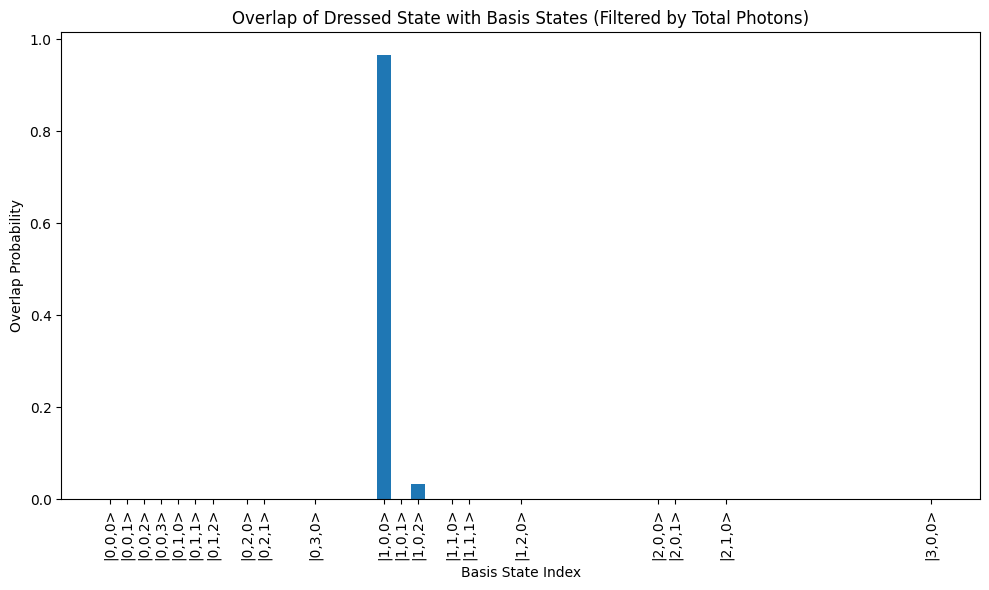

In [625]:
# Get the driven uncoupled states 

# find the modes closes to alice 
alice_state = coup_ham.basis_states[coup_ham.ket_to_basis_index('|1,0,0>')]
bob_state = coup_ham.basis_states[coup_ham.ket_to_basis_index('|0,1,0>')]

#find overlaps with floquet states (undriven states)
alice_overlap_idxs, alice_overlaps = floquet_class.find_max_overlap_indices(alice_state, f_modes, return_overlaps=True)
bob_overlap_idxs, bob_overlaps = floquet_class.find_max_overlap_indices(bob_state, f_modes, return_overlaps=True)

alice_driven_uncoupled_state = f_modes[alice_overlap_idxs[0]]
bob_driven_uncoupled_state = f_modes[bob_overlap_idxs[0]]

plus_driven_uncoupled_state = (alice_driven_uncoupled_state + bob_driven_uncoupled_state) / np.sqrt(2)
minus_driven_uncoupled_state = (alice_driven_uncoupled_state - bob_driven_uncoupled_state) / np.sqrt(2)

coup_ham.plot_dressed_state_overlap(f_modes[alice_overlap_idxs[0]])


In [630]:
# Now solve with full hamiltonian with the couplings 
H0 = coup_ham.generate_H0(no_coupling=False)
operator, time_func = coup_ham.linc_potential_operator()
args = {'amp': amp, 'omega': omegad}
H_fq = [H0, [operator, time_func]]
floquet_class = FloquetHamiltonian(H = H_fq, T=2*np.pi/omegad, args=args)
f_energies, f_modes = floquet_class.compute_floquet_modes()
# Get the driven coupled states


Adding couplings to Hamiltonian


Alice Overlap: 0.6269032491853839
Bob Overlap: 0.9694852526137687
Plus Overlap: 0.4628621978589768
Minus Overlap: 0.654660907886119


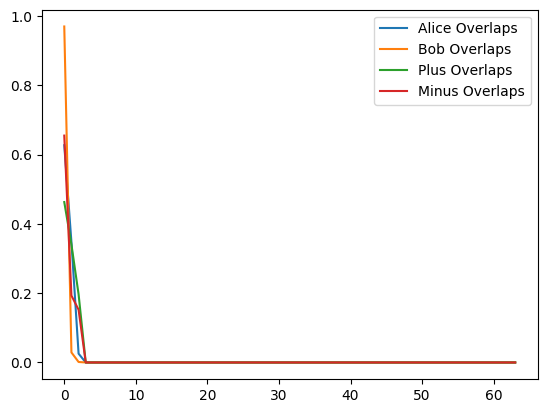

In [631]:
# compute overlaps between driven uncoupled states and driven coupled states
alice_overlap_idxs, alice_overlaps = floquet_class.find_max_overlap_indices(alice_driven_uncoupled_state, f_modes, return_overlaps=True)
bob_overlap_idxs, bob_overlaps = floquet_class.find_max_overlap_indices(bob_driven_uncoupled_state, f_modes, return_overlaps=True)

plus_overlap_idxs, plus_overlaps = floquet_class.find_max_overlap_indices(plus_driven_uncoupled_state, f_modes, return_overlaps=True)
minus_overlap_idxs, minus_overlaps = floquet_class.find_max_overlap_indices(minus_driven_uncoupled_state, f_modes, return_overlaps=True)

# print the max overlaps
print(f"Alice Overlap: {alice_overlaps[0]}")
print(f"Bob Overlap: {bob_overlaps[0]}")
print(f"Plus Overlap: {plus_overlaps[0]}")
print(f"Minus Overlap: {minus_overlaps[0]}")

plt.plot(alice_overlaps, label='Alice Overlaps')
plt.plot(bob_overlaps, label='Bob Overlaps')
plt.plot(plus_overlaps, label='Plus Overlaps')
plt.plot(minus_overlaps, label='Minus Overlaps')
plt.legend()

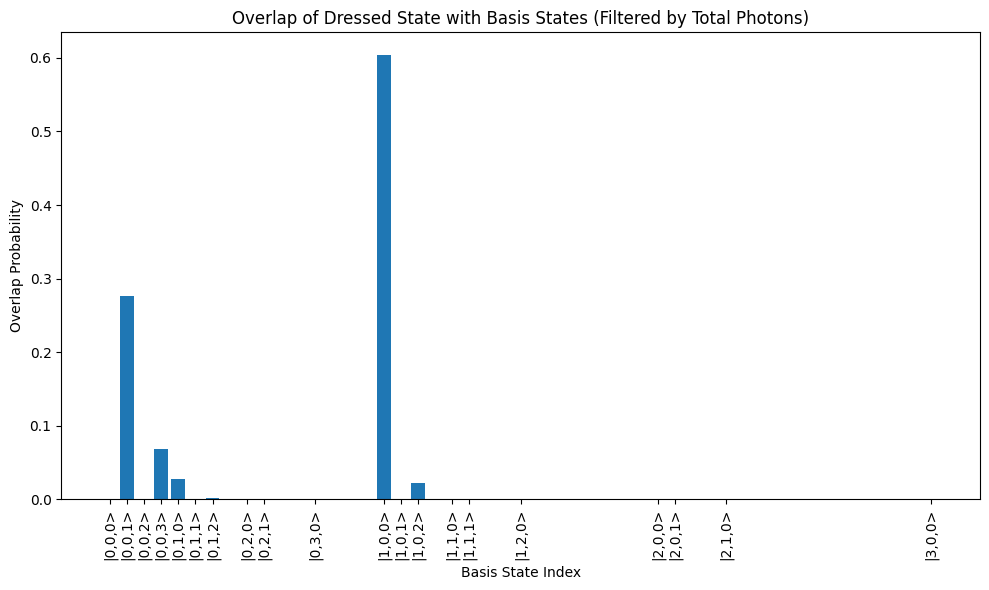

In [634]:
coup_ham.plot_dressed_state_overlap(f_modes[alice_overlap_idxs[0]])

Alice Overlap: 0.48063679438603113
Bob Overlap: 0.9188965568542662
Plus Overlap: 0.686412051990462
Minus Overlap: 0.36809172337210005


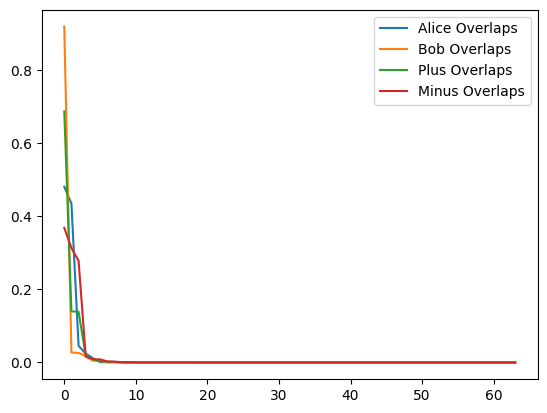

In [629]:
# compute overlaps between driven uncoupled states and driven coupled states
alice_overlap_idxs, alice_overlaps = floquet_class.find_max_overlap_indices(alice_dressed_state, f_modes, return_overlaps=True)
bob_overlap_idxs, bob_overlaps = floquet_class.find_max_overlap_indices(bob_dressed_state, f_modes, return_overlaps=True)

plus_dressed_state = (alice_dressed_state + bob_dressed_state) / np.sqrt(2)
minus_dressed_state = (alice_dressed_state - bob_dressed_state) / np.sqrt(2)

plus_overlap_idxs, plus_overlaps = floquet_class.find_max_overlap_indices(plus_dressed_state, f_modes, return_overlaps=True)
minus_overlap_idxs, minus_overlaps = floquet_class.find_max_overlap_indices(minus_dressed_state, f_modes, return_overlaps=True)

print(f"Alice Overlap: {alice_overlaps[0]}")
print(f"Bob Overlap: {bob_overlaps[0]}")
print(f"Plus Overlap: {plus_overlaps[0]}")
print(f"Minus Overlap: {minus_overlaps[0]}")

plt.plot(alice_overlaps, label='Alice Overlaps')
plt.plot(bob_overlaps, label='Bob Overlaps')
plt.plot(plus_overlaps, label='Plus Overlaps')
plt.plot(minus_overlaps, label='Minus Overlaps')
plt.legend()

### Lets do undriven vs driven sweep

In [56]:
min_freq = 1050 * 2 * np.pi
max_amp = 1150 * 2 * np.pi
amp = 0.001

In [57]:
# undriven sweep 
args = {'amp': 0, 'omega': 0}
H0 = coup_ham.generate_H0(no_coupling=True)
operator, time_func = coup_ham.linc_potential_operator()

H_fq = [H0, [operator, time_func]]
floquet_class_uncoup = FloquetHamiltonian(H = H_fq, T=2*np.pi/200, args=args)

return_args_uncoup = floquet_class_uncoup.sweep_ac_drive_frequency(amp, freq_range = (min_freq, max_amp), num_points=50)

No couplings added to Hamiltonian


Computing Floquet modes: 100%|██████████| 50/50 [00:20<00:00,  2.43it/s]


In [58]:
#driven sweep
H0 = coup_ham.generate_H0(no_coupling=False)
operator, time_func = coup_ham.linc_potential_operator()

H_fq = [H0, [operator, time_func]]
floquet_class_coup = FloquetHamiltonian(H = H_fq, T=2*np.pi/200, args=args)

return_args_coup = floquet_class_coup.sweep_ac_drive_frequency(amp, freq_range = (min_freq, max_amp), num_points=50)

Adding couplings to Hamiltonian


Computing Floquet modes: 100%|██████████| 50/50 [00:30<00:00,  1.66it/s]


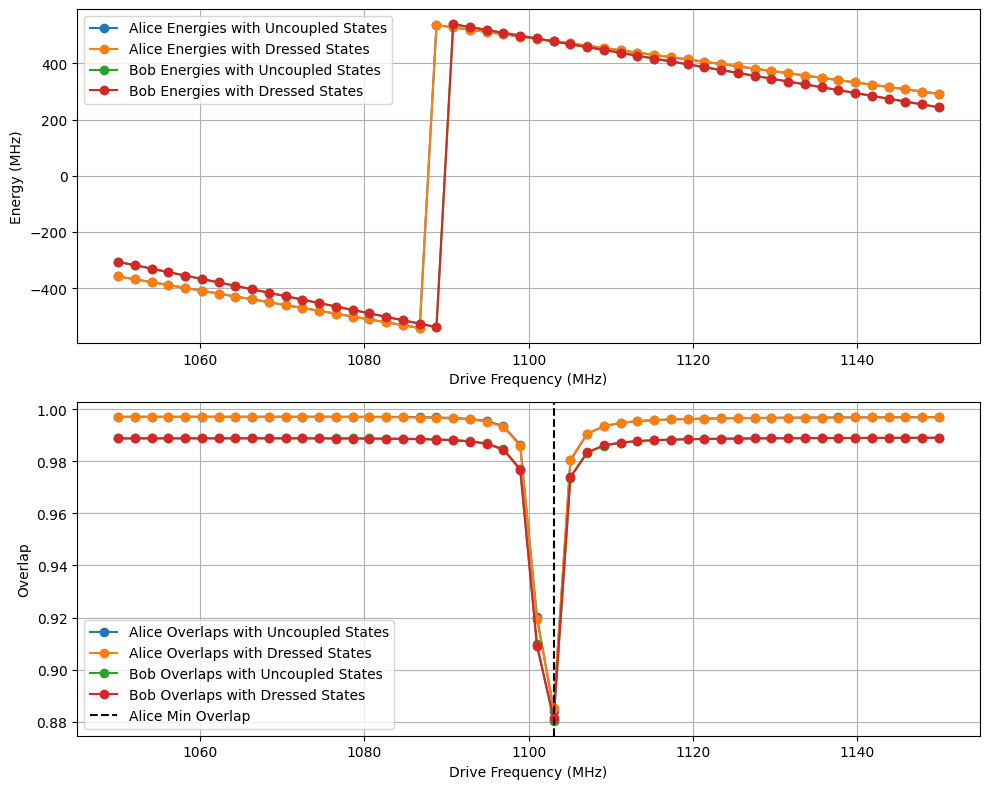

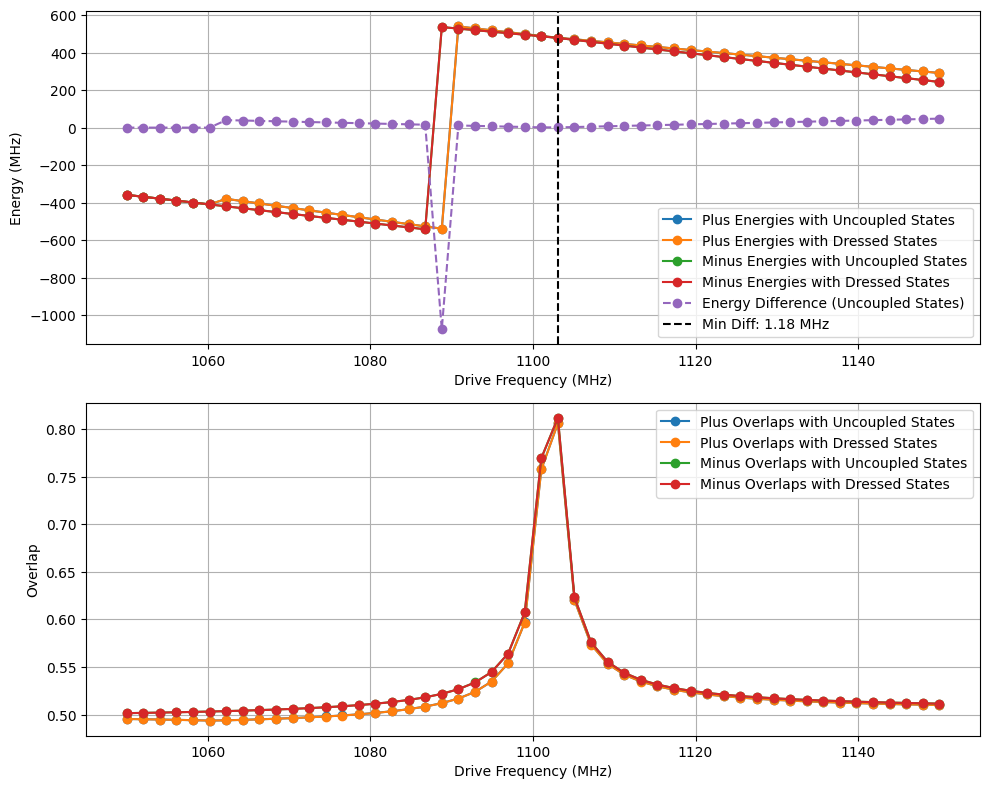

In [65]:

# Call the function for Alice and Bob
alice_results = coup_ham.calculate_coupled_uncoupled_dressed_overlaps_and_energies(
    floquet_class_uncoup, floquet_class_coup,  return_args_uncoup, return_args_coup, '|1,0,0>'
)

bob_results = coup_ham.calculate_coupled_uncoupled_dressed_overlaps_and_energies(
    floquet_class_uncoup, floquet_class_coup, return_args_uncoup, return_args_coup, '|0,1,0>'
)

min_freq, min_idx = coup_ham.plot_coupled_uncoupled_dressed_overlaps_and_energies(return_args_coup, 
                                                                 alice_results, 
                                                                 bob_results)
# Call the function for plus and minus states
plus_minus_results = coup_ham.calculate_overlaps_and_energies_plus_minus(
    floquet_class_uncoup, floquet_class_coup,  return_args_uncoup, return_args_coup, '|1,0,0>', '|0,1,0>'
)
# Plot the results for plus and minus states
min_energy_diff = coup_ham.plot_plus_minus_overlaps_and_energies(return_args_coup, return_args_uncoup, plus_minus_results, min_idx)



#### Sweep Amplitude

No couplings added to Hamiltonian


Computing Floquet modes: 100%|██████████| 30/30 [00:12<00:00,  2.48it/s]


Adding couplings to Hamiltonian


Computing Floquet modes: 100%|██████████| 30/30 [00:18<00:00,  1.66it/s]


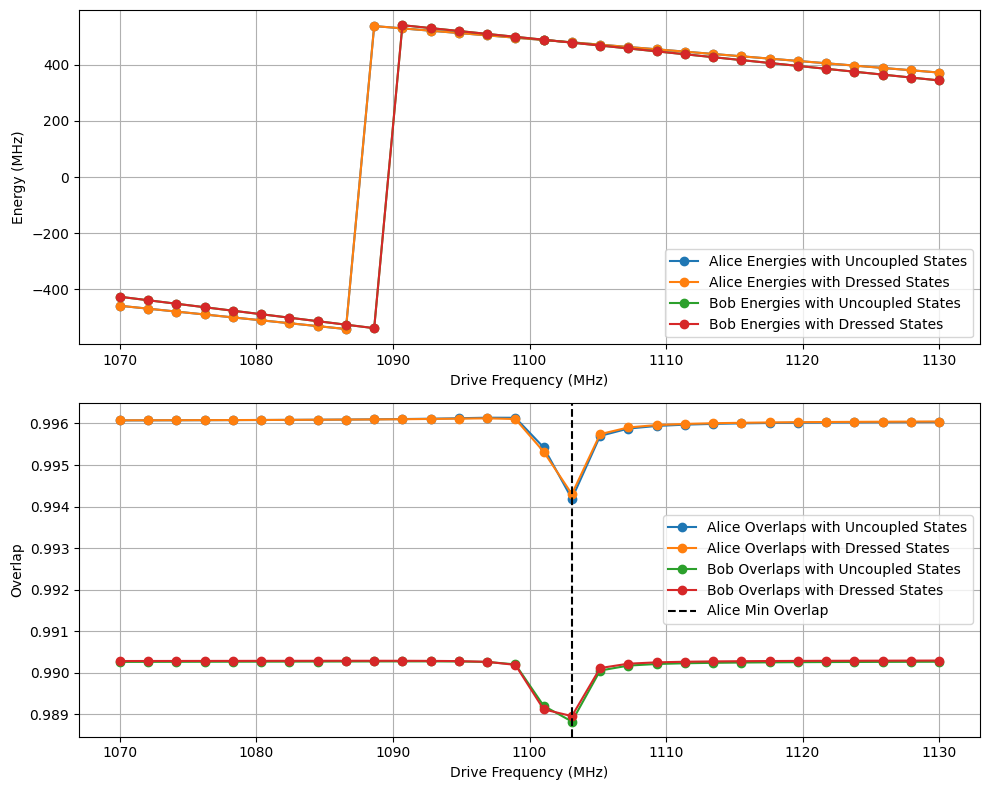

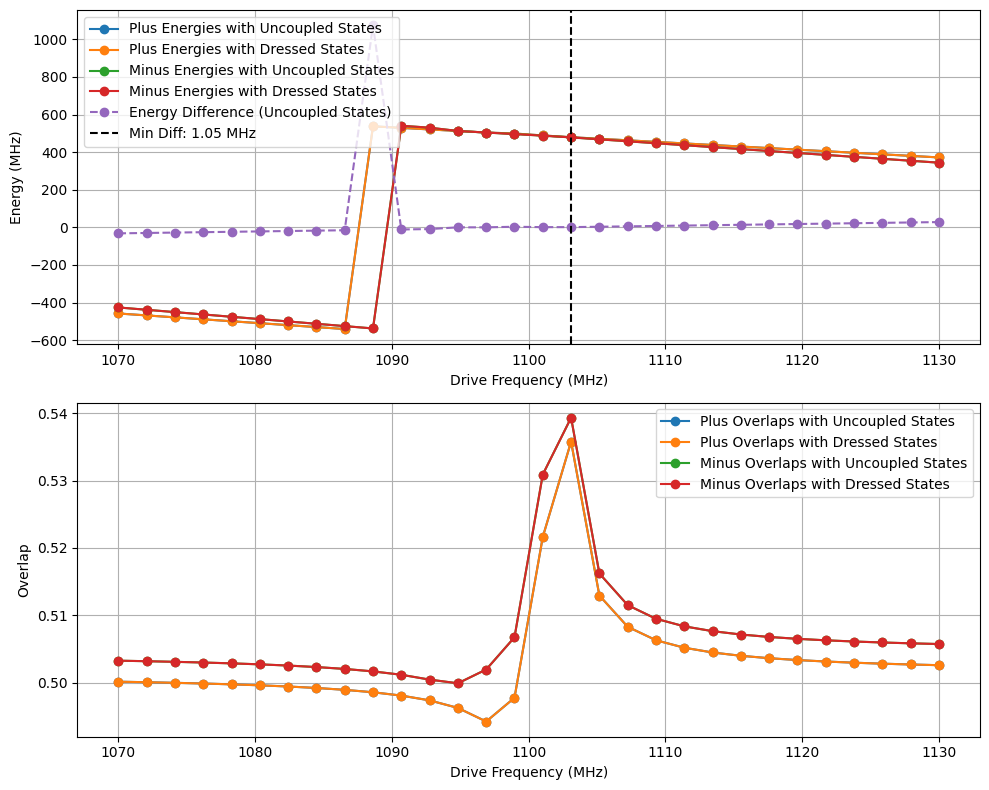

No couplings added to Hamiltonian


Computing Floquet modes: 100%|██████████| 30/30 [00:36<00:00,  1.21s/it]


Adding couplings to Hamiltonian


Computing Floquet modes: 100%|██████████| 30/30 [00:41<00:00,  1.37s/it]


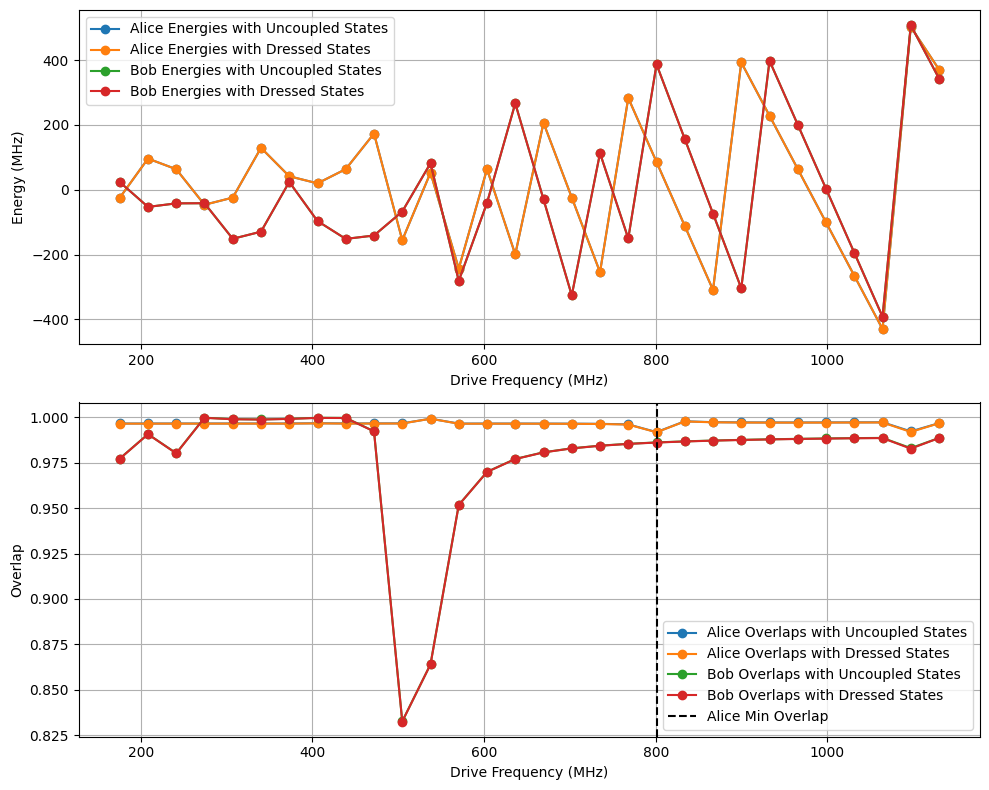

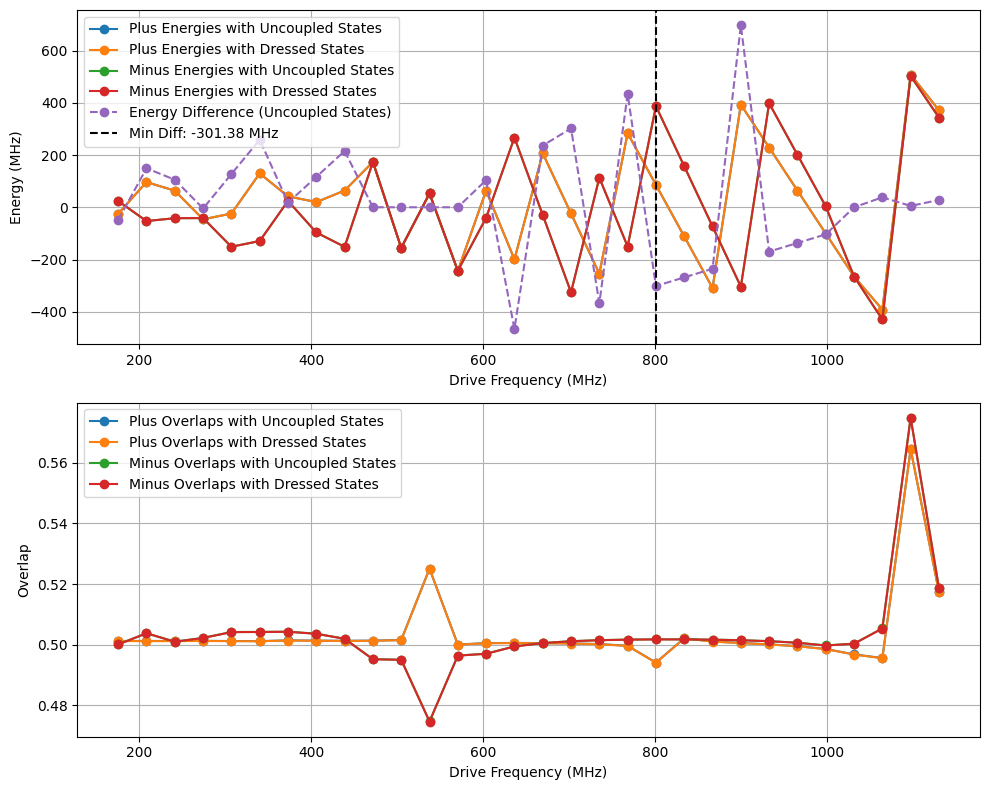

No couplings added to Hamiltonian


Computing Floquet modes: 100%|██████████| 30/30 [00:31<00:00,  1.06s/it]


Adding couplings to Hamiltonian


Computing Floquet modes: 100%|██████████| 30/30 [00:44<00:00,  1.48s/it]


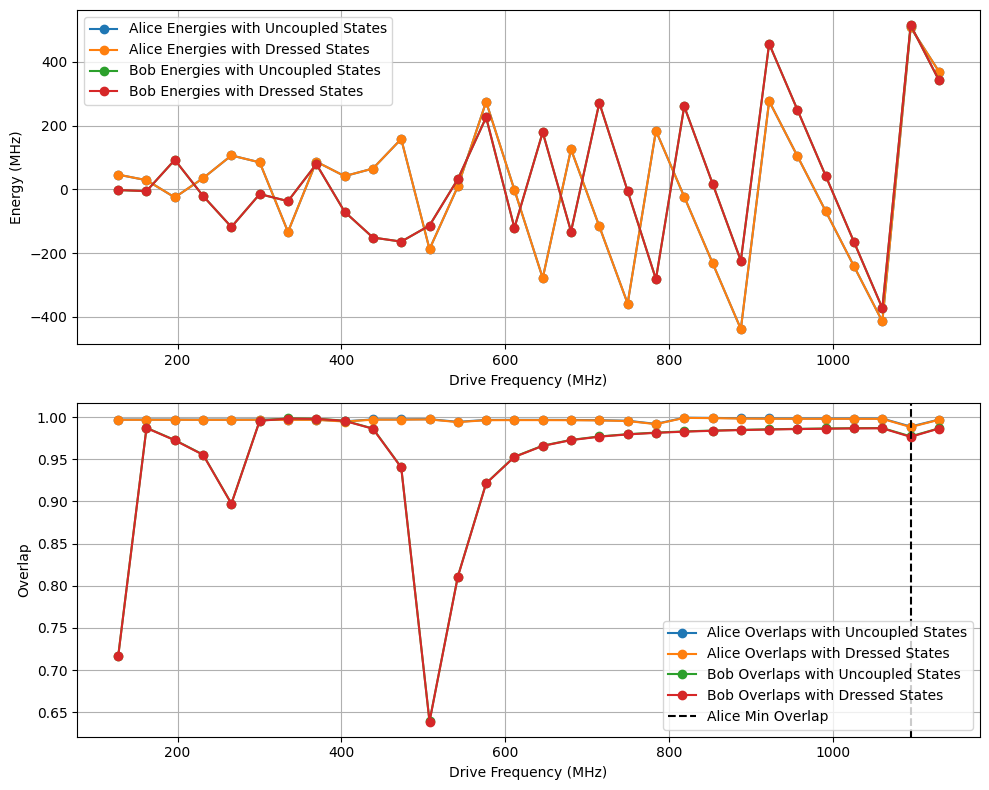

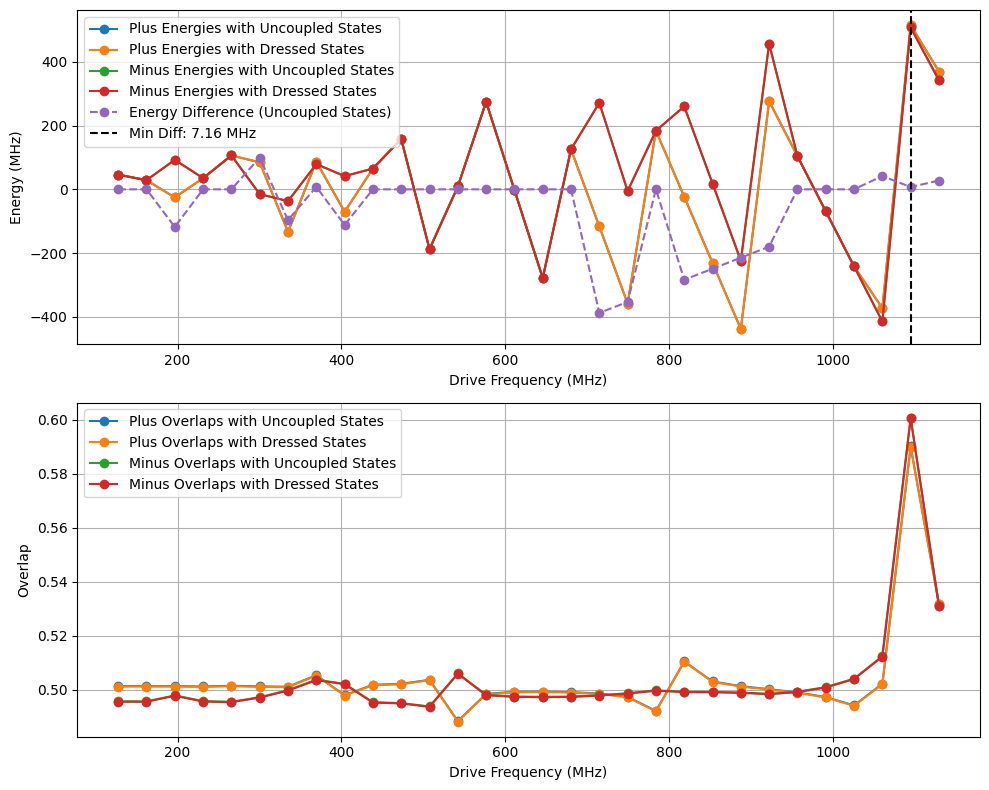

No couplings added to Hamiltonian


Computing Floquet modes: 100%|██████████| 30/30 [00:27<00:00,  1.09it/s]


Adding couplings to Hamiltonian


Computing Floquet modes: 100%|██████████| 30/30 [00:40<00:00,  1.34s/it]


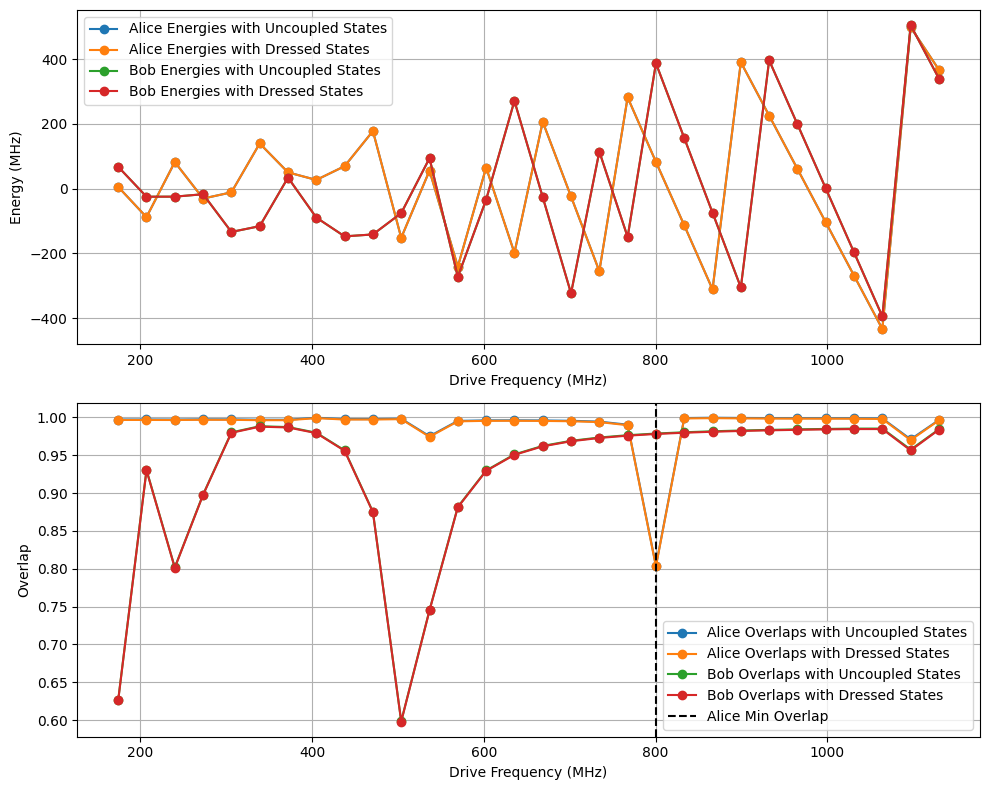

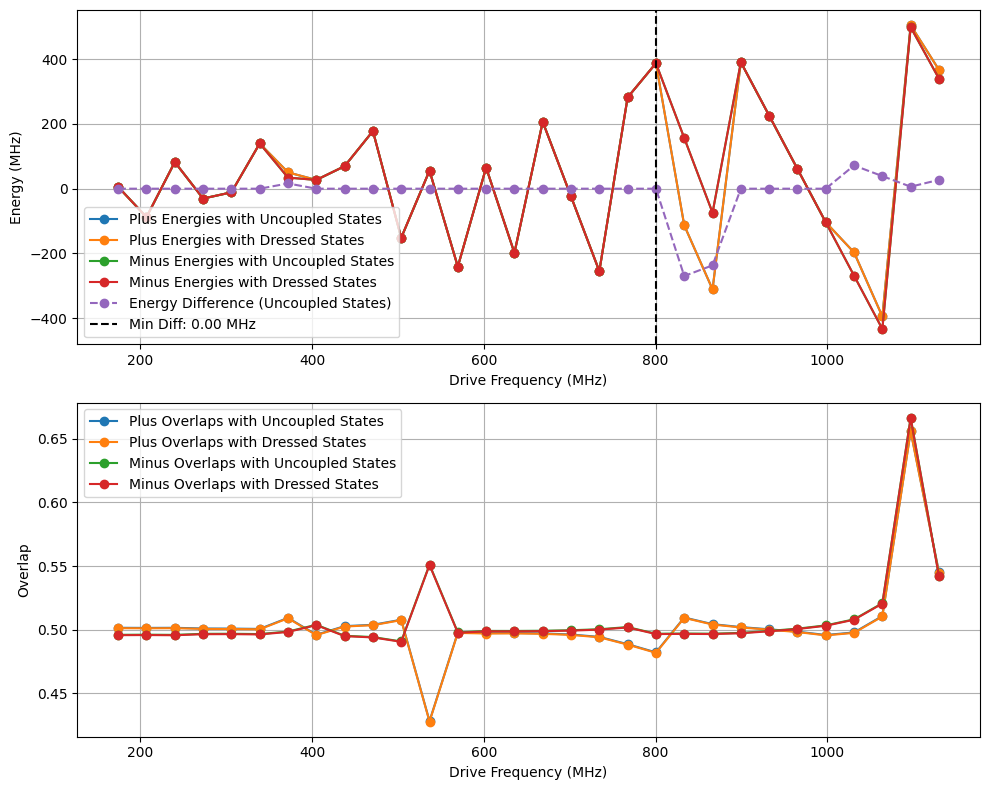

No couplings added to Hamiltonian


Computing Floquet modes: 100%|██████████| 30/30 [00:31<00:00,  1.04s/it]


Adding couplings to Hamiltonian


Computing Floquet modes: 100%|██████████| 30/30 [00:46<00:00,  1.54s/it]


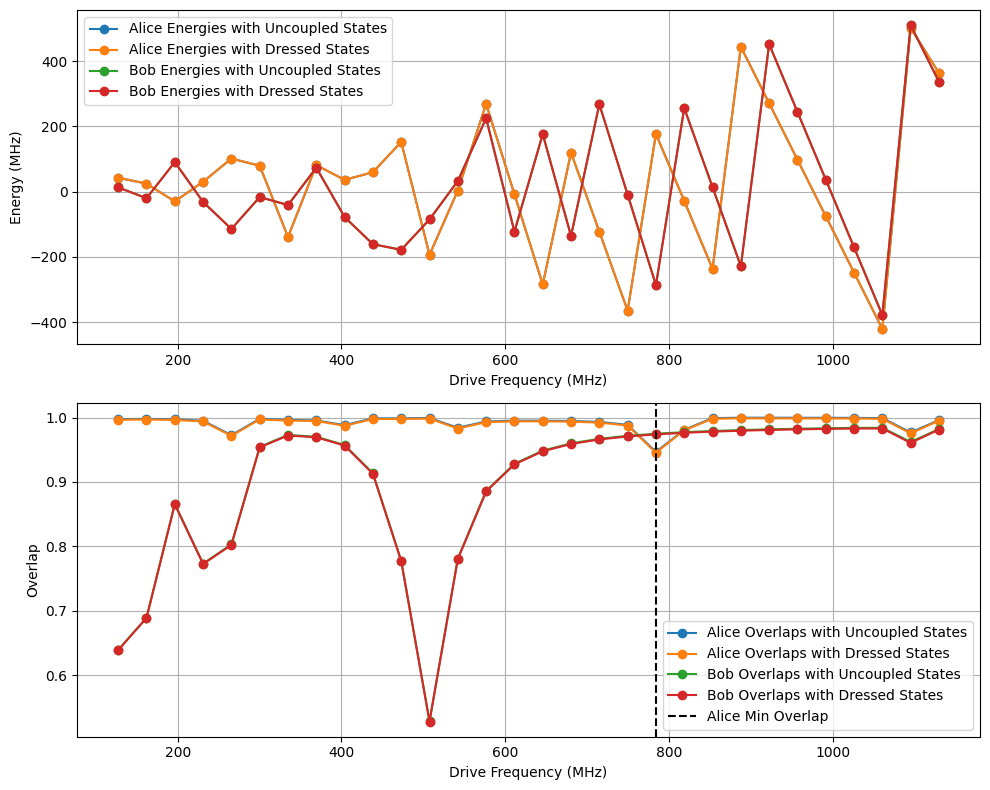

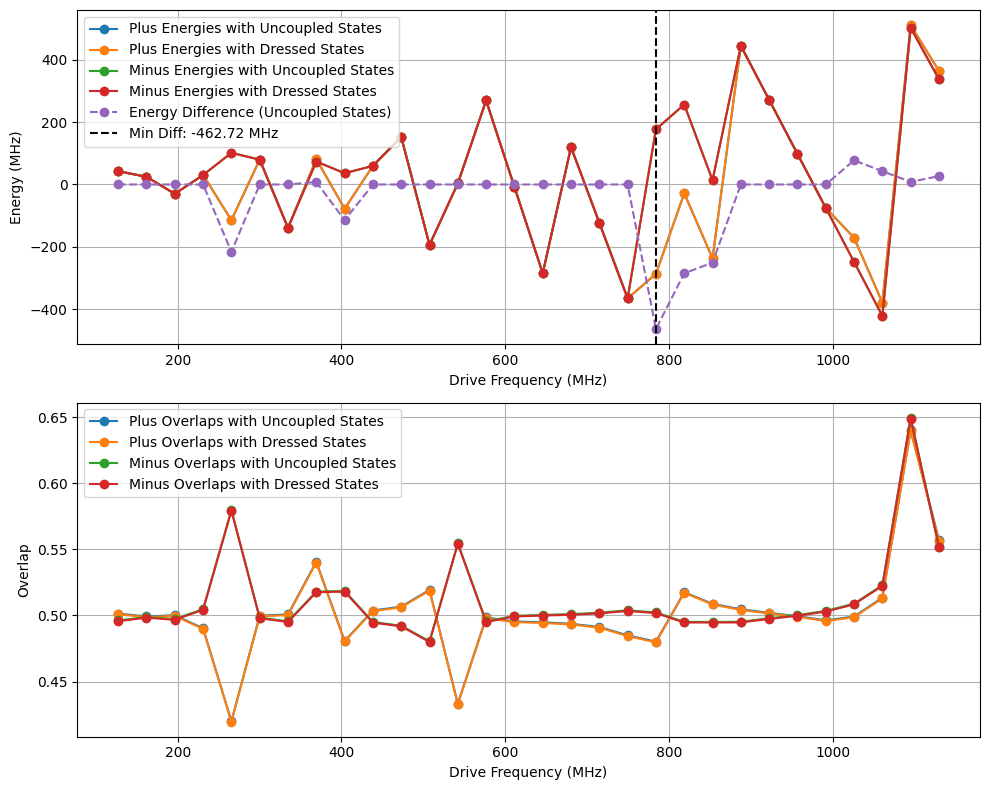

No couplings added to Hamiltonian


Computing Floquet modes: 100%|██████████| 30/30 [00:31<00:00,  1.05s/it]


Adding couplings to Hamiltonian


Computing Floquet modes:  10%|█         | 3/30 [00:12<01:50,  4.09s/it]

In [ ]:
amp_list = np.linspace(0.0001, 0.03, 30)  # Amplitude sweep range
min_freq = 1070 * 2 * np.pi
max_amp = 1130 * 2 * np.pi
freq_pts = 30
delta_bs = []
g_bs = []
results = []

for idx, amp in enumerate(amp_list):
    # uncoupled case 
    H0 = coup_ham.generate_H0(no_coupling=True)
    operator, time_func = coup_ham.linc_potential_operator()

    H_fq = [H0, [operator, time_func]]
    floquet_class_uncoup = FloquetHamiltonian(H = H_fq, T=2*np.pi/200, args=args)

    return_args_uncoup = floquet_class_uncoup.sweep_ac_drive_frequency(amp, freq_range = (min_freq, max_amp), num_points=freq_pts)

    # coupled case

    H0 = coup_ham.generate_H0(no_coupling=False)
    operator, time_func = coup_ham.linc_potential_operator()

    H_fq = [H0, [operator, time_func]]
    floquet_class_coup = FloquetHamiltonian(H = H_fq, T=2*np.pi/200, args=args)

    return_args_coup = floquet_class_coup.sweep_ac_drive_frequency(amp, freq_range = (min_freq, max_amp), num_points=freq_pts)

    # Analysis

    
    # Call the function for Alice and Bob
    alice_results = coup_ham.calculate_coupled_uncoupled_dressed_overlaps_and_energies(
        floquet_class_uncoup, floquet_class_coup,  return_args_uncoup, return_args_coup, '|1,0,0>'
    )

    bob_results = coup_ham.calculate_coupled_uncoupled_dressed_overlaps_and_energies(
        floquet_class_uncoup, floquet_class_coup, return_args_uncoup, return_args_coup, '|0,1,0>'
    )

    min_freq, min_idx = coup_ham.plot_coupled_uncoupled_dressed_overlaps_and_energies(return_args_coup, 
                                                                    alice_results, 
                                                                    bob_results)
    # Call the function for plus and minus states
    plus_minus_results = coup_ham.calculate_overlaps_and_energies_plus_minus(
        floquet_class_uncoup, floquet_class_coup,  return_args_uncoup, return_args_coup, '|1,0,0>', '|0,1,0>'
    )
    # Plot the results for plus and minus states
    min_energy_diff = coup_ham.plot_plus_minus_overlaps_and_energies(return_args_coup, return_args_uncoup, plus_minus_results, min_idx)

    delta_bs.append(min_freq)
    g_bs.append(min_energy_diff)
    results.append({'alice': alice_results, 'bob': bob_results, 'plus_minus': plus_minus_results,})


#### Debug

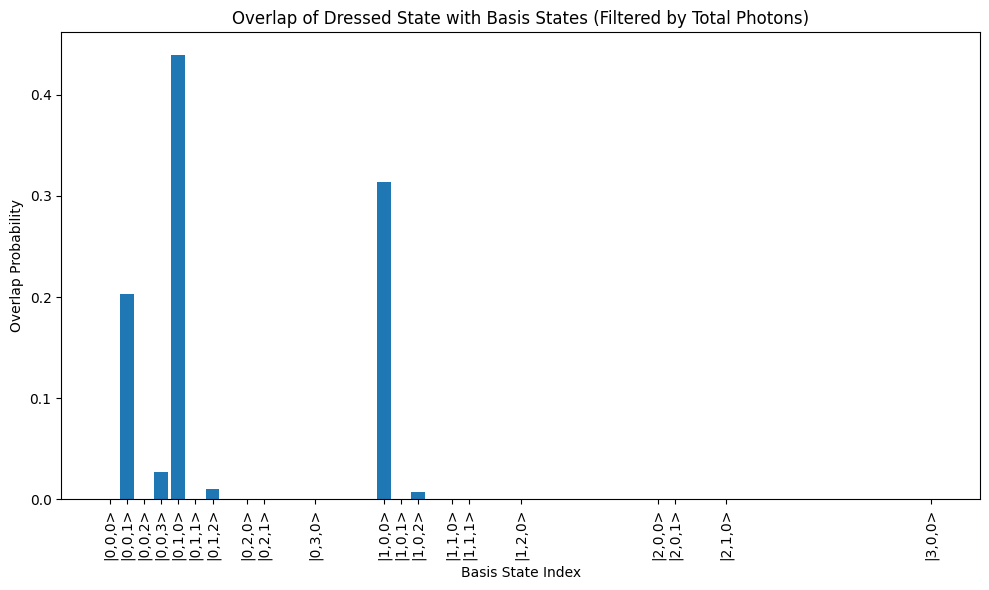

Overlap with uncoupled state: 0.4497847012563616


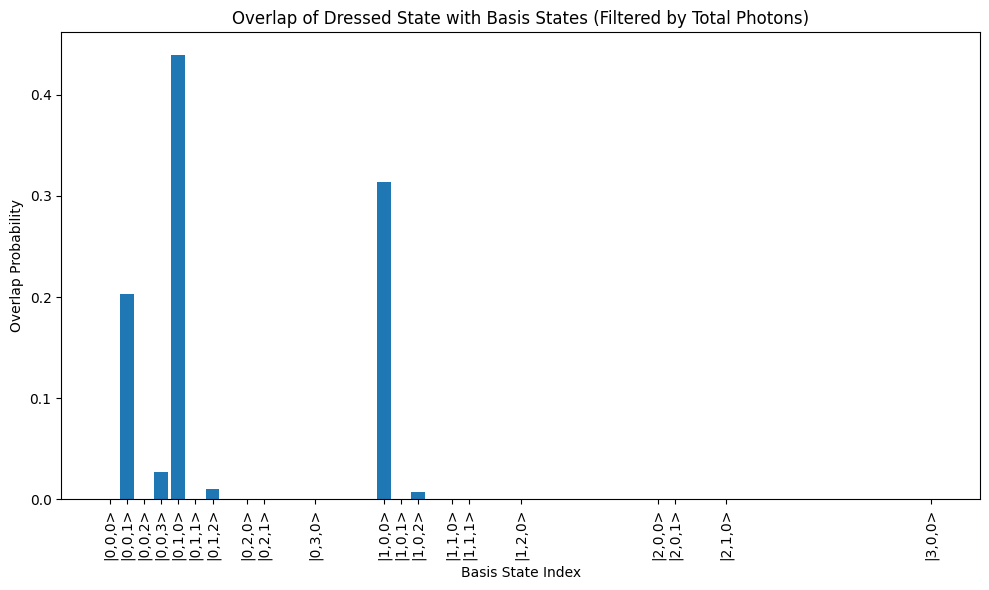

Overlap with dressed state: 0.5088686853073212


In [26]:
idx = 33
alice_state = coup_ham.basis_states[coup_ham.ket_to_basis_index('|0,1,0>')]
# find the alice state in the uncoupled modes
alice_overlap_idxs, alice_overlaps = floquet_class_uncoup.find_max_overlap_indices(alice_state, return_args_uncoup['modes'][idx], return_overlaps=True)
alice_driven_uncoupled_state = return_args_uncoup['modes'][idx][alice_overlap_idxs[0]]

# find the states in driven coupled modes which is closest to the uncoupled state
alice_overlap_idxs, alice_overlaps = floquet_class_coup.find_max_overlap_indices(alice_driven_uncoupled_state, return_args_coup['modes'][idx], return_overlaps=True)
# alice_overlaps_coup_with_uncoupled.append(alice_overlaps[0])
# plot the coupled alice mode
coup_ham.plot_dressed_state_overlap(return_args_coup['modes'][idx][alice_overlap_idxs[0]])
print(f"Overlap with uncoupled state: {alice_overlaps[0]}")

# find the state in driven coupled modes which is closest to the dressed state
alice_overlap_dressed_idxs, alice_overlaps_dressed = floquet_class_coup.find_max_overlap_indices(coup_ham.dressed_states[coup_ham.basis_to_dressed_mapping_dict[coup_ham.ket_to_basis_index('|0,1,0>')]], return_args_coup['modes'][idx], return_overlaps=True)
# alice_overlaps_coup_with_dressed.append(alice_overlaps_dressed[0])
# plot the coupled alice mode
coup_ham.plot_dressed_state_overlap(return_args_coup['modes'][idx][alice_overlap_dressed_idxs[0]])
print(f"Overlap with dressed state: {alice_overlaps_dressed[0]}")


### Back to main

In [ ]:
# now get floquet modes 
omegad = 2 * np.pi * 500 # Floquet drive frequency
amp = 0.2
H0 = coup_ham.H0
operator, time_func = coup_ham.linc_potential_operator()
args = {'amp': amp, 'omega': omegad}
H_fq = [H0, [operator, time_func]]

# return_dict = coup_ham.sweep_ac_drive_frequency(H_fq, amp, freq_range=(2 * np.pi * 375, 2 * np.pi * 425), num_points=10)


In [553]:
omegad = 2 * np.pi * 500 
args = {'amp': 0.02, 'omega': omegad}
floquet_class= FloquetHamiltonian(H = H_fq, T=2*np.pi/omegad, args=args)
ens, modes = floquet_class.compute_floquet_modes()


/opt/anaconda3/envs/quantum/lib/python3.12/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


In [560]:

floquet_class_= FloquetHamiltonian(H = H_fq, T=2*np.pi/omega_drive, args=args)
min_freq = 480 * 2 * np.pi
max_amp = 520 * 2 * np.pi
amp = 0.2
return_args = floquet_class.sweep_ac_drive_frequency(amp, freq_range = (min_freq, max_amp), num_points=20)

Computing Floquet modes: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


In [561]:
freqs = return_args['frequencies']
energies = return_args['energies']
modes = return_args['modes']

# plot alice state 
alice_state = '|1,0,0>'
alice_dressed_state = coup_ham.dressed_states[coup_ham.basis_to_dressed_mapping_dict[coup_ham.ket_to_basis_index(alice_state)]]

# do same for bob state
bob_state = '|0,1,0>'
bob_dressed_state = coup_ham.dressed_states[coup_ham.basis_to_dressed_mapping_dict[coup_ham.ket_to_basis_index(bob_state)]]

Max overlap at index 1: 0.8366474498666698 for swept parameter 482.10526315789474
Min overlap at index 9: 0.3562146376447429 for swept parameter 498.9473684210526
Max overlap at index 1: 0.8585038761529307 for swept parameter 482.10526315789474
Min overlap at index 19: 0.2543449857559821 for swept parameter 520.0


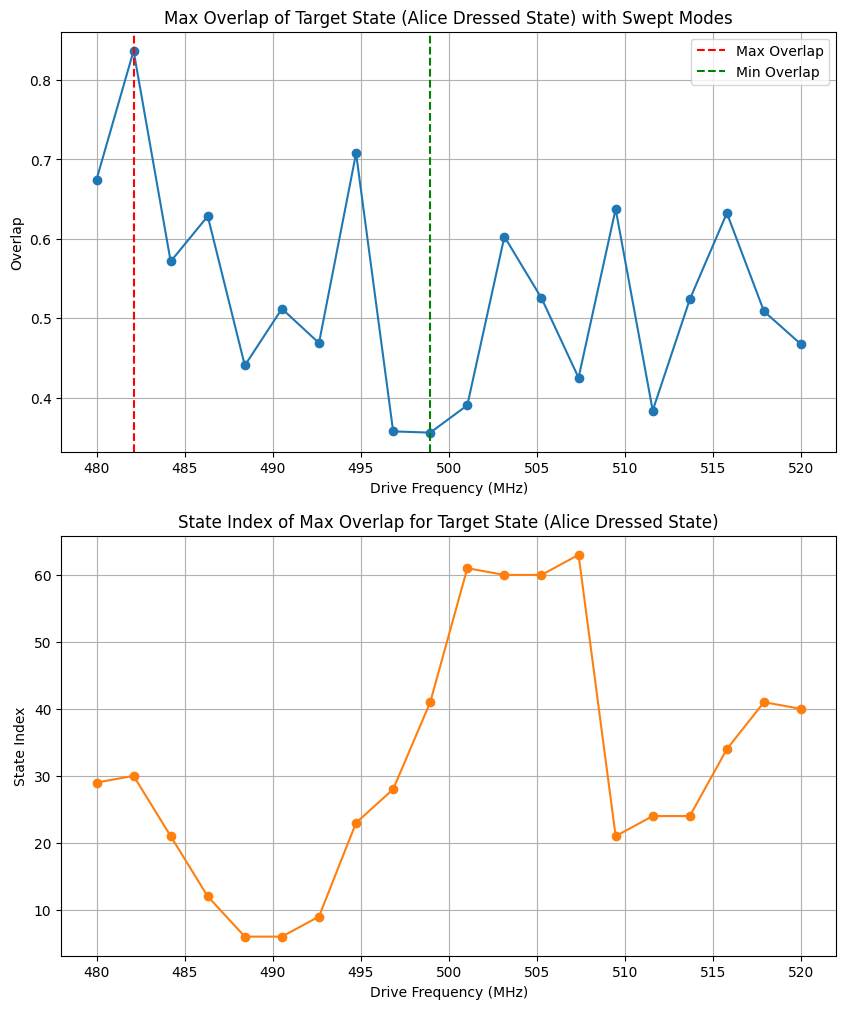

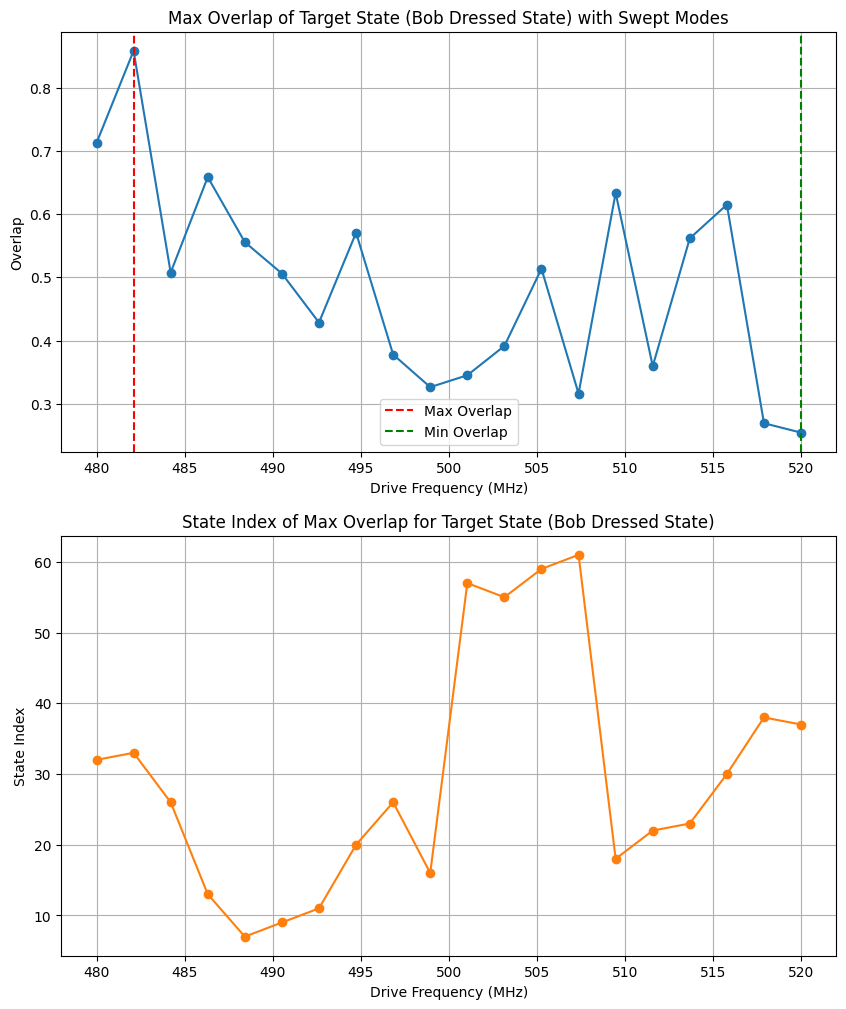

In [566]:
plus_state = (alice_dressed_state + bob_dressed_state) / np.sqrt(2)
minus_state = (alice_dressed_state - bob_dressed_state) / np.sqrt(2)

return_args_plotting = floquet_class.plot_overlaps_states(swept_list=freqs/2/np.pi,
                                                           target_states=[alice_dressed_state, bob_dressed_state],#,
                                                                          # plus_state, minus_state],
                                                           target_state_labels=['Alice Dressed State', 'Bob Dressed State', 'Plus', 'Minus'],
                                                           modes_swept_list= modes,
                                                              xlabel='Drive Frequency (MHz)', ylabel='Overlap',
                                                                find_min=True, find_max = True)

In [515]:
return_args_plotting[0].keys()

dict_keys(['swept_list', 'overlap_values', 'overlap_idxs', 'max_overlap_idx', 'min_overlap_idx'])

Alice index for frequency 482.11 MHz: 1
Overlaps with dressed states: [1.2367990894259497e-33, 0.03559833225331254, 0.8366474498666698, 0.07831050425519802, 1.1378438567741942e-31, 2.2644966553004566e-31, 3.1445740429966706e-34, 6.828294626364917e-32, 1.0847119765146658e-31, 6.254829688095965e-33, 0.010228344470383535, 0.008432689986251707, 0.000357272803495475, 0.010045946095591767, 0.0001980365081840799, 0.00012236240021514563, 0.00014553073783697267, 7.987654545928664e-05, 3.945584094137908e-05, 8.8530042409728e-06, 3.274657575579253e-32, 6.421957182697796e-32, 1.675874402565274e-33, 4.27576911386054e-33, 2.1517912440040767e-33, 1.4296542596837453e-32, 3.6503664135224606e-33, 1.5893814774432813e-31, 1.2534759957155704e-31, 6.181709052690708e-32, 6.426194120277838e-32, 3.2080567326646815e-30, 0.014930588239101275, 0.0032149465696176683, 0.00013224441510392286, 1.1771275457786765e-06, 0.0007281221981366926, 0.00019126148546906975, 4.181947030462669e-08, 0.00016992260488250444, 2.07916

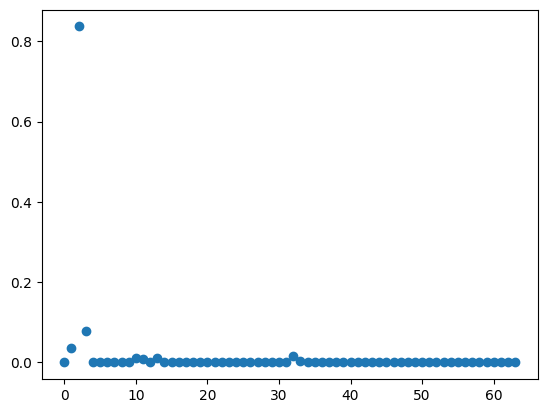

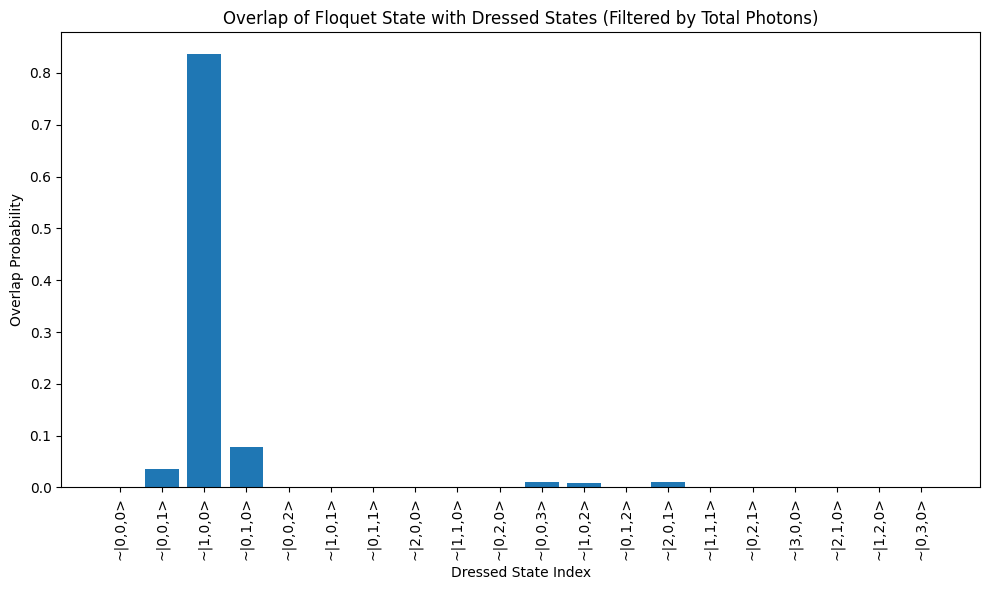

In [564]:
alice_idx_for_freq = return_args_plotting[0]['max_overlap_idx'] # where dip happends
print(f"Alice index for frequency {freqs[alice_idx_for_freq]/2/np.pi:.2f} MHz: {alice_idx_for_freq}")
alice_floquet_mode_state = modes[alice_idx_for_freq][return_args_plotting[0]['overlap_idxs'][alice_idx_for_freq]]
coup_ham.plot_floquet_state_overlap(alice_floquet_mode_state)

In [524]:
alice_floquet_mode_state

Quantum object: dims=[[4, 4], [1]], shape=(16, 1), type='ket', dtype=Dense
Qobj data =
[[-2.17530617e-22-1.73422170e-23j]
 [ 1.00000000e+00+0.00000000e+00j]
 [ 5.08551338e-20-4.97818007e-20j]
 [-1.08576109e-13+4.65852409e-15j]
 [-2.02120921e-10-2.12349316e-05j]
 [ 1.44231820e-16-9.69226220e-16j]
 [-1.82909324e-12-1.86476348e-07j]
 [ 3.92551678e-16+2.02140522e-16j]
 [ 4.80238362e-20-6.61143633e-20j]
 [-4.05578537e-12+6.76831883e-17j]
 [-1.75779976e-19+8.82862955e-20j]
 [-3.01145916e-14+7.76798263e-19j]
 [-5.07136463e-23+3.52980030e-18j]
 [-1.21120145e-15-2.09583998e-15j]
 [ 2.20348809e-23+6.70479150e-19j]
 [ 2.89180321e-15+3.93818770e-16j]]

Alice overlap indices: [61, 5, 62, 57, 19, 3, 8, 1, 6, 22, 24, 26, 16, 40, 23, 13, 42, 37, 59, 39, 11, 50, 14, 43, 55, 28, 53, 46, 29, 35, 32, 48, 25, 52, 54, 0, 51, 56, 7, 36, 60, 10, 41, 34, 21, 2, 45, 4, 38, 63, 9, 30, 12, 58, 47, 15, 44, 33, 18, 20, 31, 17, 49, 27]
Overlaps with dressed states: [1.167883392334791e-31, 0.009774296759339803, 0.39065205173695716, 0.1676406483101312, 4.750563349837526e-31, 4.5330729441729e-31, 6.518269567881709e-31, 7.219617115175569e-32, 6.794460567300177e-31, 5.795397328122405e-31, 0.0003893291030427148, 0.16958443263412595, 0.11498533980733315, 0.047363122582847125, 0.00029101894645299815, 0.006176593877208814, 0.07232770322462684, 0.001830951034305626, 1.9374218550923887e-05, 0.0012448970194136584, 7.225420871359461e-33, 2.8475866435851556e-31, 3.7265006471714735e-31, 7.5577406676759025e-31, 6.555707817348871e-32, 7.229200204069992e-32, 4.04365618631254e-33, 1.7796054432715363e-31, 1.1600983077675512e-31, 3.449518735202792e-31, 1.518306152329696e-3

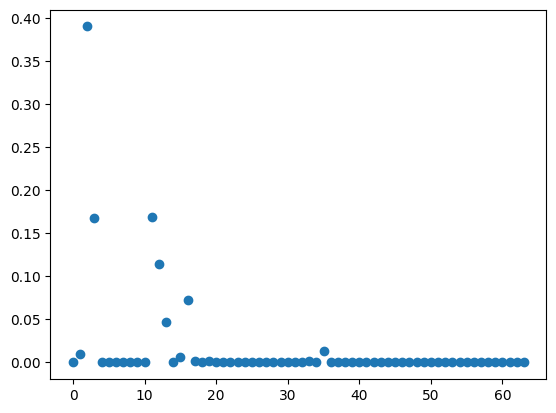

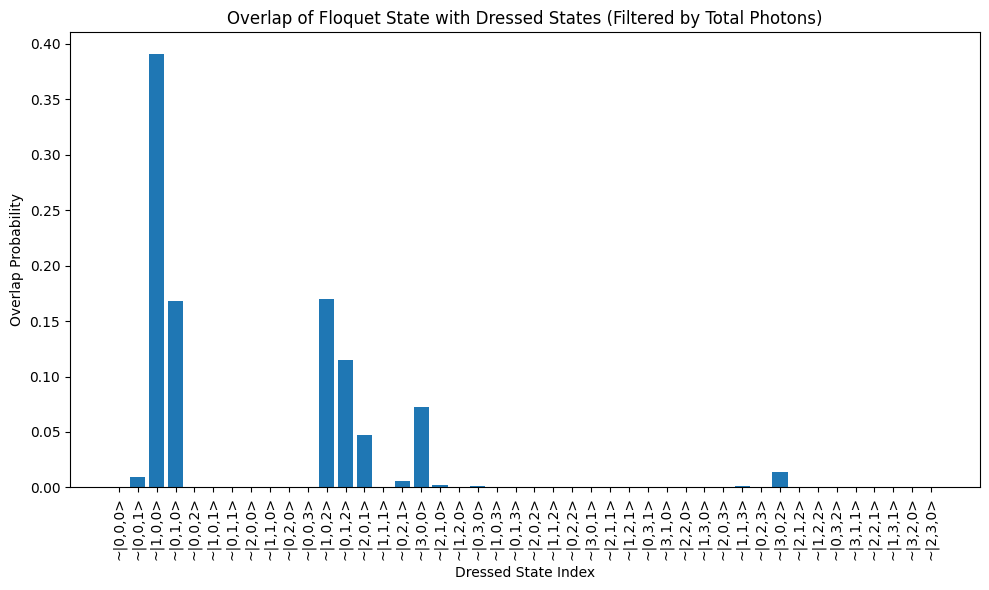

In [598]:
plus_state = (alice_dressed_state + bob_dressed_state) / np.sqrt(2)
minus_state = (alice_dressed_state - bob_dressed_state) / np.sqrt(2)

freq_idx = 10
alice_overlap_indices, alice_overlap = floquet_class_.find_max_overlap_indices(plus_state, modes[freq_idx], return_overlaps=True)
print(f"Alice overlap indices: {alice_overlap_indices}")
alice_floquet_state = modes[freq_idx][alice_overlap_indices[0]]
# alice_floquet_state = modes[freq_idx][28]
coup_ham.plot_floquet_state_overlap(alice_floquet_state, max_total_photons=5)

In [596]:
freq_index

166

In [597]:
alice_overlap_indices[0]

61

In [541]:
len(modes[0])

16

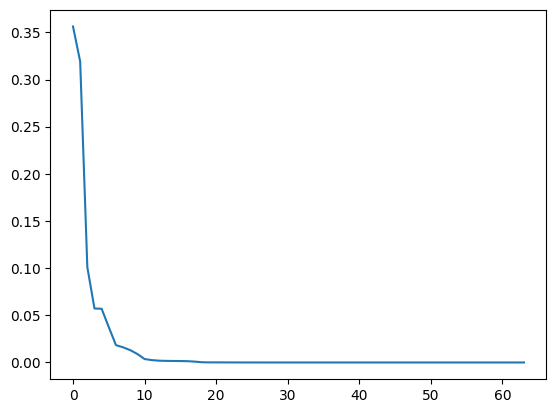

In [575]:
plt.plot(alice_overlap)

In [535]:
modes[50]

[Quantum object: dims=[[4, 4], [1]], shape=(16, 1), type='ket', dtype=Dense
 Qobj data =
 [[-5.10070342e-24+2.29822857e-21j]
  [ 5.06287232e-17+1.78942094e-16j]
  [-1.12471045e-16+5.86178466e-16j]
  [ 1.56103632e-20-2.17780175e-18j]
  [ 7.78110509e-19-9.75010582e-20j]
  [-5.22262201e-14-6.93980485e-17j]
  [-2.51570091e-16-1.13519397e-16j]
  [-5.02371246e-13+1.96075633e-14j]
  [ 2.15436264e-16+2.61151327e-16j]
  [-8.69483156e-23+7.42183446e-22j]
  [ 2.59963691e-10-3.95745705e-07j]
  [ 6.37350641e-23-2.06274678e-22j]
  [ 1.56651977e-27+1.75405267e-28j]
  [-2.98581055e-13-6.51910968e-15j]
  [-3.09765000e-27-8.64706062e-28j]
  [ 1.00000000e+00+0.00000000e+00j]],
 Quantum object: dims=[[4, 4], [1]], shape=(16, 1), type='ket', dtype=Dense
 Qobj data =
 [[-4.39392830e-37-3.65470550e-37j]
  [-3.01335952e-14-8.69839720e-18j]
  [-1.44554507e-22+2.63868953e-22j]
  [-2.87032166e-13+3.55180198e-15j]
  [ 2.01961440e-17-1.03342448e-17j]
  [ 1.00111518e-27+2.29073739e-28j]
  [ 5.84137497e-11-3.2307571

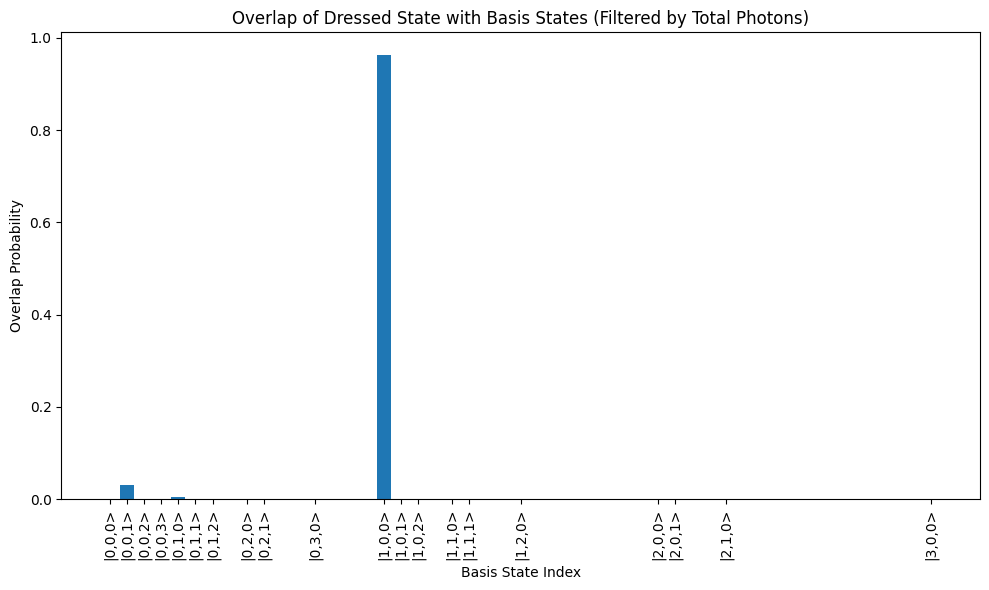

In [536]:
coup_ham.plot_dressed_state_overlap(alice_dressed_state)

In [517]:
return_args_plotting[0].keys()

dict_keys(['swept_list', 'overlap_values', 'overlap_idxs', 'max_overlap_idx', 'min_overlap_idx'])

In [521]:
return_args_plotting[0]['overlap_idxs'][alice_idx_for_freq]


13

In [ ]:
plus_plotting = return_args_plotting[-2]
minus_plotting = return_args_plotting[-1]
plus_plotting.keys()


dict_keys(['swept_list', 'overlap_values', 'overlap_idxs', 'max_overlap_idx', 'min_overlap_idx'])

In [477]:


# get the indices of max overlap for plus and minus states
plus_max_overlap_idx = plus_plotting['max_overlap_idx']
plus_max_overlap_mode_idx = plus_plotting['overlap_idxs'][plus_max_overlap_idx]
minus_max_overlap_idx = minus_plotting['max_overlap_idx']
minus_max_overlap_mode_idx = minus_plotting['overlap_idxs'][minus_max_overlap_idx]

# get the corresponding energies 
plus_energy = energies[plus_max_overlap_idx][plus_max_overlap_mode_idx]
minus_energy = energies[minus_max_overlap_idx][minus_max_overlap_mode_idx]
print(f"Plus state energy at 500 MHz: {plus_energy / 2 / np.pi:.2f} MHz")
print(f"Minus state energy at 500 MHz: {minus_energy / 2 / np.pi:.2f} MHz")
# effecive g is the difference in energy between the plus and minus states
energy_diff = minus_energy - plus_energy
print(f"Energy difference at 500 MHz: {energy_diff / 2 / np.pi:.2f} MHz")

Plus state energy at 500 MHz: 200.00 MHz
Minus state energy at 500 MHz: 2.02 MHz
Energy difference at 500 MHz: -197.98 MHz


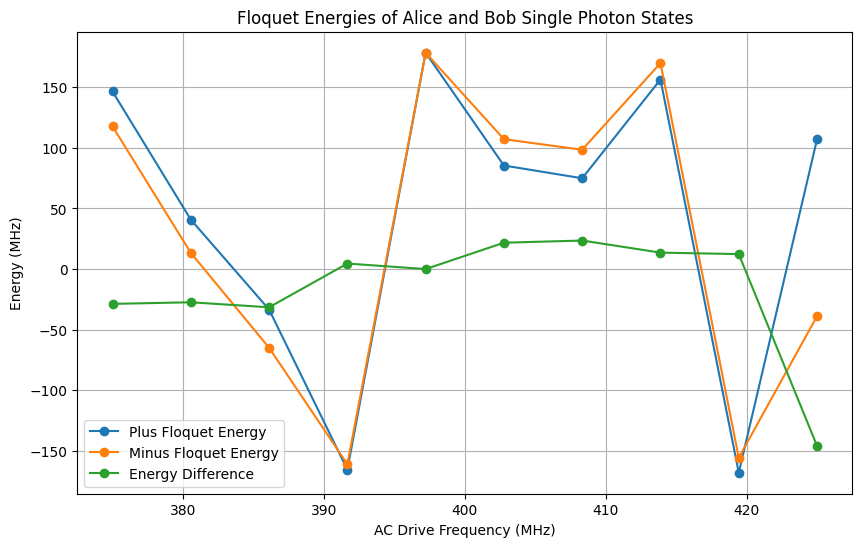

In [292]:
frequencies, energies, modes, mappings = return_dict['frequencies'], return_dict['energies'], return_dict['modes'], return_dict['mappings']

# compute alice and bob single photon dressed state energies as well as differences 
alice_floquet_energies = []
bob_floquet_energies = []
plus_floquet_energies = []
minus_floquet_energies = []
for idx, freq in enumerate(frequencies):
    H_fq = [H0, [operator, time_func]]
    f_energies, f_modes = energies[idx], modes[idx]
    dressed_to_floquet_mapping = mappings['dressed_to_floquet'][idx]
    floquet_to_dressed_mapping = mappings['floquet_to_dressed'][idx]
    
    alice_floquet_idx = dressed_to_floquet_mapping[coup_ham.basis_to_dressed_mapping_dict[coup_ham.ket_to_basis_index('|1,0,0>')]]
    bob_floquet_idx = dressed_to_floquet_mapping[coup_ham.basis_to_dressed_mapping_dict[coup_ham.ket_to_basis_index('|0,1,0>')]]
    alice_floquet_energies.append(f_energies[alice_floquet_idx])
    bob_floquet_energies.append(f_energies[bob_floquet_idx])


    alice_dressed_idx = coup_ham.basis_to_dressed_mapping_dict[coup_ham.ket_to_basis_index('|1,0,0>')]
    bob_dressed_idx = coup_ham.basis_to_dressed_mapping_dict[coup_ham.ket_to_basis_index('|0,1,0>')]
    alice_dressed_state = coup_ham.dressed_states[alice_dressed_idx]
    bob_dressed_state = coup_ham.dressed_states[bob_dressed_idx]

    plus_state = (alice_dressed_state + bob_dressed_state) / np.sqrt(2)
    minus_state = (alice_dressed_state - bob_dressed_state) / np.sqrt(2)

    # Find the floquet states with largest overlap with the plus and minus states
    plus_floquet = f_modes[coup_ham.find_max_overlap_indices(plus_state, f_modes)[0]]
    minus_floquet = f_modes[coup_ham.find_max_overlap_indices(minus_state, f_modes)[0]]
    plus_floquet_energy = f_energies[coup_ham.find_max_overlap_indices(plus_state, f_modes)[0]]
    minus_floquet_energy = f_energies[coup_ham.find_max_overlap_indices(minus_state, f_modes)[0]]
    plus_floquet_energies.append(plus_floquet_energy)
    minus_floquet_energies.append(minus_floquet_energy)


    
# Convert to numpy arrays for easier manipulation
alice_floquet_energies = np.array(alice_floquet_energies)
bob_floquet_energies = np.array(bob_floquet_energies)
plus_floquet_energies = np.array(plus_floquet_energies)
minus_floquet_energies = np.array(minus_floquet_energies)

# Plot the absolute energies and the energy difference
plt.figure(figsize=(10, 6))
# plt.plot(frequencies / (2 * np.pi), alice_floquet_energies / (2 * np.pi), label='Alice Single Photon Floquet Energy', marker='o')
# plt.plot(frequencies / (2 * np.pi), bob_floquet_energies / (2 * np.pi), label='Bob Single Photon Floquet Energy', marker='o')
# plt.plot(frequencies / (2 * np.pi), (bob_floquet_energies - alice_floquet_energies) / (2 * np.pi), label='Energy Difference', marker='o')
#plot the plus and minus floquet energies
plt.plot(frequencies / (2 * np.pi), plus_floquet_energies / (2 * np.pi), label='Plus Floquet Energy', marker='o')
plt.plot(frequencies / (2 * np.pi), minus_floquet_energies / (2 * np.pi), label='Minus Floquet Energy', marker='o')
#plot difference between plus and minus energies
plt.plot(frequencies / (2 * np.pi), (minus_floquet_energies - plus_floquet_energies) / (2 * np.pi), label='Energy Difference', marker='o')
plt.xlabel('AC Drive Frequency (MHz)')
plt.ylabel('Energy (MHz)')
plt.title('Floquet Energies of Alice and Bob Single Photon States')
plt.legend()
plt.grid()
plt.show()

In [291]:
frequencies / (2 * np.pi)

array([375.        , 380.55555556, 386.11111111, 391.66666667,
       397.22222222, 402.77777778, 408.33333333, 413.88888889,
       419.44444444, 425.        ])

In [ ]:

amplitudes, energies, modes, mappings = return_dict['amplitudes'], return_dict['energies'], return_dict['modes'], return_dict['mappings']

# compute alice and bob single photon dressed state energies as well as differences 
alice_floquet_energies = []
bob_floquet_energies = []
for idx, amp in enumerate(amplitudes):
    H_fq = [H0, [operator, time_func]]
    f_energies, f_modes = energies[idx], modes[idx]
    dressed_to_floquet_mapping = mappings['dressed_to_floquet'][idx]
    floquet_to_dressed_mapping = mappings['floquet_to_dressed'][idx]
    
    alice_floquet_idx = dressed_to_floquet_mapping[coup_ham.basis_to_dressed_mapping_dict[coup_ham.ket_to_basis_index('|1,0,0>')]]
    bob_floquet_idx = dressed_to_floquet_mapping[coup_ham.basis_to_dressed_mapping_dict[coup_ham.ket_to_basis_index('|0,1,0>')]]
    
    alice_floquet_energies.append(f_energies[alice_floquet_idx])
    bob_floquet_energies.append(f_energies[bob_floquet_idx])
# Convert to numpy arrays for easier manipulation
alice_floquet_energies = np.array(alice_floquet_energies)
bob_floquet_energies = np.array(bob_floquet_energies)

# Plot the absolute energies and the energy difference
plt.figure(figsize=(10, 6))
plt.plot(amplitudes, alice_floquet_energies / (2 * np.pi), label='Alice Single Photon Floquet Energy', marker='o')
plt.plot(amplitudes, bob_floquet_energies / (2 * np.pi), label='Bob Single Photon Floquet Energy', marker='o')
plt.plot(amplitudes, (bob_floquet_energies - alice_floquet_energies) / (2 * np.pi), label='Energy Difference', marker='o')
plt.xlabel('AC Drive Amplitude (phi_AC_amp)')
plt.ylabel('Energy (MHz)')
plt.title('Floquet Energies of Alice and Bob Single Photon States')
plt.legend()
plt.grid()
plt.show()

KeyError: 'amplitudes'

In [236]:
dressed_to_floquet_mapping[2]

1

In [123]:
operator

Quantum object: dims=[[5, 5, 5], [5, 5, 5]], shape=(125, 125), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 2.39846439e-05  0.00000000e+00 -1.03769820e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.22768043e-04  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.03769820e-04  0.00000000e+00  6.10353204e-05 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  6.10353204e-05
   0.00000000e+00  3.20868271e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   2.44679836e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  3.20868271e-05
   0.00000000e+00 -3.32002383e-06]]

In [ ]:
s

In [97]:
coup_ham.generate_H0()/2/np.pi

Quantum object: dims=[[5, 5, 5], [5, 5, 5]], shape=(125, 125), type='oper', dtype=Dia, isherm=True
Qobj data =
[[    0.     0.     0. ...     0.     0.     0.]
 [    0.  4000.     0. ...     0.     0.     0.]
 [    0.     0.  8000. ...     0.     0.     0.]
 ...
 [    0.     0.     0. ... 52000.     0.     0.]
 [    0.     0.     0. ...     0. 56000.     0.]
 [    0.     0.     0. ...     0.     0. 60000.]]

In [98]:
quasienergies

array([-5.19649817e-06, -3.58720499e-06, -2.59428541e-06, -2.00326726e-06,
       -0.00000000e+00,  8.34470853e-06,  3.43124620e-05,  3.43124687e-05,
        8.64484887e-05,  1.81275238e-04,  1.81275253e-04,  3.42381709e-04,
        6.02403460e-04,  6.02403475e-04,  1.00531485e-03,  1.00531485e-03,
        1.60904643e-03,  1.60904643e-03,  1.60904645e-03,  2.48843985e-03,
        2.48843987e-03,  3.73855107e-03,  3.73855107e-03,  3.73855110e-03,
        5.47831127e-03,  5.47831128e-03,  7.85455528e-03,  7.85455528e-03,
        7.85455528e-03,  1.10464261e-02,  1.10464261e-02,  1.10464261e-02,
        1.52701662e-02,  1.52701662e-02,  1.52701662e-02,  1.52701662e-02,
        2.07843050e-02,  2.07843050e-02,  2.07843050e-02,  2.78952564e-02,
        2.78952565e-02,  2.78952565e-02,  2.78952565e-02,  3.69633397e-02,
        3.69633397e-02,  4.84092411e-02,  4.84092411e-02,  4.84092411e-02,
        4.84092411e-02,  6.27209379e-02,  6.27209379e-02,  6.27209379e-02,
        6.27209379e-02,  

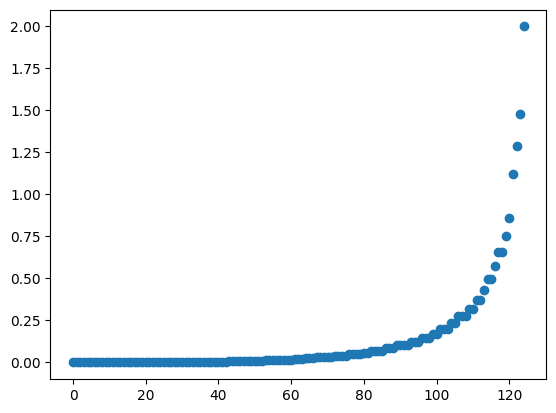

In [99]:
plt.plot(quasienergies/2/np.pi, 'o')

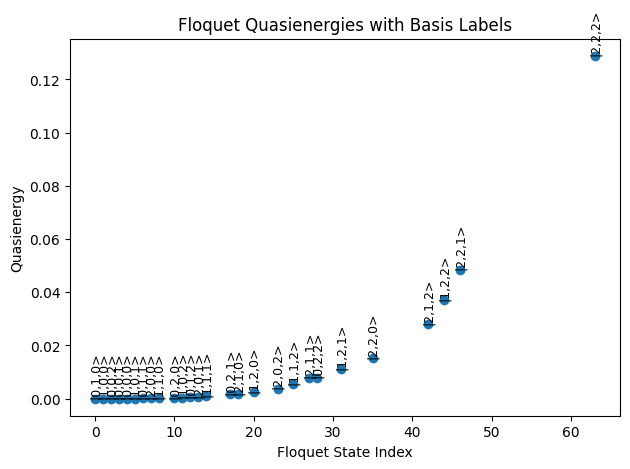

In [100]:
coup_ham.plot_floquet_energies( states, quasienergies)#, title="LINC potential quasienergies")

In [101]:
energies, modes = coup_ham.compute_states_over_floquet_period(omega =omegad, H = H, num_points = 10)


Computing Floquet states: 100%|██████████| 10/10 [00:23<00:00,  2.31s/it]


5
25
2
1
0
26
6
50
30
3
10
27
7
51
31
75
4
11
55
28
35
15
8
52
76
32
100
56
12
29
80
36
53
16
9
60
77
40
33
13
101
20
57
81
37
17
61
105
54
78
41
85
34
102
65
58
21
14
82
45
38
18
106
62
42
79
86
103
66
110
59
22
90
83
46
39
19
70
107
63
43
87
104
67
23
111
91
84
47
108
115
71
64
44
95
88
68
112
24
48
92
109
116
72
96
89
120
113
69
93
49
73
117
97
114
121
94
118
74
98
122
119
99
123
124


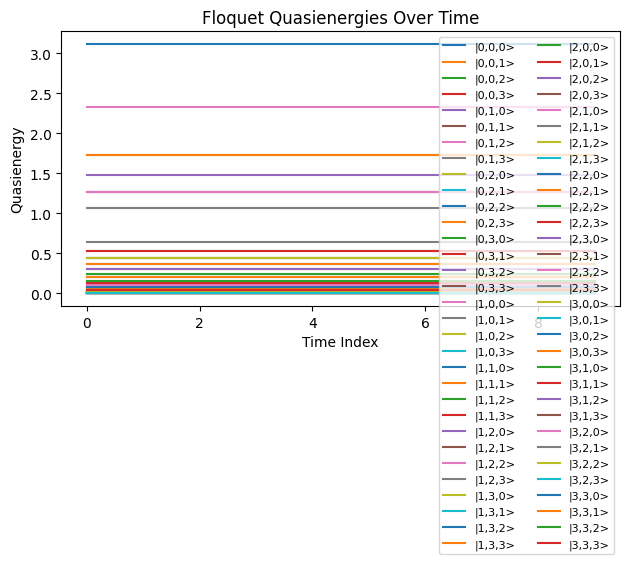

In [102]:
coup_ham.plot_floquet_energies_over_period(energies, modes, max_photons_per_mode=3)

In [ ]:
num_points = len(energies)
keys = big_mapping_list[0].keys()
en_for_state = np.zeros(( len(keys), num_points))
for j, key in enumerate(keys):
    en_for_state[j, :] = [big_mapping_list[i][key] for i in range(num_points)]




{0: 66,
 1: 61,
 2: 91,
 3: 36,
 4: 17,
 5: 42,
 6: 31,
 7: 16,
 8: 37,
 9: 32,
 10: 96,
 11: 27,
 12: 2,
 13: 117,
 14: 87,
 15: 112,
 16: 82,
 17: 107,
 18: 77,
 19: 102,
 20: 22,
 21: 47,
 22: 72,
 23: 122,
 24: 97,
 25: 26,
 26: 1,
 27: 1,
 28: 56,
 29: 61,
 30: 6,
 31: 86,
 32: 51,
 33: 76,
 34: 11,
 35: 41,
 36: 56,
 37: 16,
 38: 81,
 39: 91,
 40: 86,
 41: 101,
 42: 106,
 43: 96,
 44: 71,
 45: 111,
 46: 46,
 47: 21,
 48: 92,
 49: 37,
 50: 12,
 51: 17,
 52: 42,
 53: 7,
 54: 12,
 55: 37,
 56: 62,
 57: 27,
 58: 32,
 59: 57,
 60: 52,
 61: 87,
 62: 90,
 63: 121,
 64: 80,
 65: 77,
 66: 70,
 67: 45,
 68: 20,
 69: 95,
 70: 112,
 71: 107,
 72: 117,
 73: 78,
 74: 3,
 75: 28,
 76: 33,
 77: 8,
 78: 38,
 79: 53,
 80: 13,
 81: 64,
 82: 63,
 83: 78,
 84: 68,
 85: 83,
 86: 18,
 87: 43,
 88: 18,
 89: 93,
 90: 120,
 91: 39,
 92: 94,
 93: 84,
 94: 79,
 95: 19,
 96: 14,
 97: 9,
 98: 39,
 99: 44,
 100: 4,
 101: 29,
 102: 34,
 103: 54,
 104: 59,
 105: 63,
 106: 88,
 107: 98,
 108: 103,
 109: 73,
 110: